
Licensed under the Apache License, Version 2.0

Enable TPUs for the notebook: Navigate to Edit→Notebook Settings and
select TPU from the Hardware Accelerator drop-down.

Replace the value for BUCKET and PROJECT_ID with your Google Cloud Bucket and project. This is necessary to write files. Make sure you have read and write access to this bucket. Then run the cells consecutively.

In [ ]:
BUCKET = ''
PROJECT_ID = ''

In [ ]:
"""Runs TPU Saint-Venant Simulations."""

TPU_WORKER = ''  # pylint: disable=g-statement-before-imports
PUBLIC_COLAB = True  # pylint: disable=g-statement-before-imports

if PUBLIC_COLAB:
  # Authenticate to access Google Cloud Storage.
  from google.colab import auth  # pylint: disable=g-import-not-at-top
  auth.authenticate_user()
# Access DEM from Google Cloud Storage and use GCS for runtime files.

import abc
import collections
import enum
import functools
import io
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import os
from skimage import transform
import tempfile
import time
from typing import Any, Callable, Iterable, Sequence, List, Dict, Mapping, MutableMapping, MutableSequence, Optional, Text, Tuple, Union

import attr
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

if PUBLIC_COLAB:
  from google.cloud import storage  # pylint: disable=g-import-not-at-top
  import ipywidgets as widgets  # pylint: disable=g-import-not-at-top
  from osgeo import gdal  # pylint: disable=g-import-not-at-top

if PUBLIC_COLAB:
  from tensorflow.python.ops import gen_resource_variable_ops  # pylint: disable=g-import-not-at-top
  from tensorflow.python.ops import inplace_ops  # pylint: disable=g-import-not-at-top
  from tensorflow.python.tpu.ops import tpu_ops  # pylint: disable=g-import-not-at-top

# Floating point tolerance for timesteps.
TIMESTEP_EPS = 1e-5
# Floating point tolerance used in Saint-Venant step function.
SAINT_VENANT_EPS = 1e-15
_G = 9.8
# Manning coefficient defaults. NB: The simulation can be more accurate if a
# river mask is provided which defines th river region of the DEM. In that case,
# `MANNING_COEFF_FLOODPLAIN` is used in the non-river region (i.e., the
# floodplain region). In the Conawy example, we take a simpler approach and use
# `np.ones()` for the river mask, so `MANNING_COEFF_FLOODPLAIN` is unused.
MANNING_COEFF_FLOODPLAIN = 0.05
MANNING_COEFF_RIVER = 0.02

# The dynamic states are:
#   h: the absolute height
#   q_x: The water flow in the x direction.
#   q_y: The water flow in the y direction.
#   t: The current simulation time.
#   dt: The timestep size. Note that `dt` is held constant in this simulation.
_H = 'h'
_Q_X = 'q_x'
_Q_Y = 'q_y'
_T = 't'
_DT = 'dt'

INIT_STATE_KEYS = [_H, _Q_X, _Q_Y]
STATE_KEYS = INIT_STATE_KEYS + [_T, _DT]

# The static states are:
#   m: The Manning coefficient matrix.
#   e: The water bed elevation.
# We also specify the boundaries using {L,R,T,B}_BOUNDARIES.
_M = 'm'
_E = 'e'

_I_L_BOUNDARY = 'i_left_boundary'
_I_R_BOUNDARY = 'i_right_boundary'
_I_T_BOUNDARY = 'i_top_boundary'
_I_B_BOUNDARY = 'i_bottom_boundary'

_O_L_BOUNDARY = 'o_left_boundary'
_O_R_BOUNDARY = 'o_right_boundary'
_O_T_BOUNDARY = 'o_top_boundary'
_O_B_BOUNDARY = 'o_bottom_boundary'

_M_L_BOUNDARY = 'm_left_boundary'
_M_R_BOUNDARY = 'm_right_boundary'
_M_T_BOUNDARY = 'm_top_boundary'
_M_B_BOUNDARY = 'm_bottom_boundary'

L_BOUNDARIES = (_I_L_BOUNDARY, _M_L_BOUNDARY, _O_L_BOUNDARY)
R_BOUNDARIES = (_I_R_BOUNDARY, _M_R_BOUNDARY, _O_R_BOUNDARY)
T_BOUNDARIES = (_I_T_BOUNDARY, _M_T_BOUNDARY, _O_T_BOUNDARY)
B_BOUNDARIES = (_I_B_BOUNDARY, _M_B_BOUNDARY, _O_B_BOUNDARY)

ADDITIONAL_STATE_KEYS = [
    _M, _E, *L_BOUNDARIES, *R_BOUNDARIES, *T_BOUNDARIES, *B_BOUNDARIES
]
SER_EXTENSION = 'ser'
TensorMap = Mapping[Text, tf.Tensor]
TensorOrArray = Union[tf.Tensor, np.ndarray]
ThreeIntTuple = Tuple[int, int, int]
ExtractSubgridFn = Callable[[TensorOrArray,
                             'GridParametrization',
                             ThreeIntTuple], TensorOrArray]
MutableTensorMap = MutableMapping[Text, tf.Tensor]
FnOutput = Tuple[List[tf.Tensor], MutableTensorMap]
StepOutput = List[List[tf.Tensor]]
StepBuilder = Callable[[], StepOutput]

KeyedInitialValues = Mapping[Text, Union[int, float, complex, Text, bool,
                                         np.ndarray, tf.Tensor]]
MutableKeyedInitialValues = MutableMapping[Text,
                                           Union[int, float, complex, Text,
                                                 bool, np.ndarray, tf.Tensor]]
InputFiles = collections.namedtuple('InputFiles', ['file_name', 'dtype'])


class BoundarySide(enum.Enum):
  """A representation of boundary sides."""
  LEFT = 0
  RIGHT = 1
  TOP = 2
  BOTTOM = 3


class SideType(enum.Enum):
  """A class defining the type of axis side."""
  LOW = 1  # The low side of an axis.
  HIGH = 2  # The high side of an axis.


class BCType(enum.Enum):
  """A class defining the type of boundary conditions.

  NO_TOUCH: Preserves the boundary at its current value: useful when the grid is
    staggered. Namely, if certain state variables are defined and computed only
    for interior grid points, their extremal values are already correct and do
    not need to be re-calculated/have a boundary condition imposed outside of
    the computation loop.
  ADDITIVE: Similar to a Neumann condition, but adds the supplied boundary
    values to the boundary plane itself, as opposed to the plane +/- 1.
  """
  NO_TOUCH = 1  # Preserves the boundary at its current value.
  ADDITIVE = 2  # Adds the given values at the boundary.


class BoundaryCondition:
  """The base class for boundary conditions."""

  def __init__(self,
               boundary_side: BoundarySide,
               fraction_start: float,
               fraction_end: float,
               left_padding: int,
               top_padding: int,
               unpadded_shape: Sequence[int],
               slope: float):
    self.boundary_side = boundary_side
    self.slope = slope
    self._top_bottom = boundary_side in [BoundarySide.TOP, BoundarySide.BOTTOM]
    self.unpadded_side_length = unpadded_shape[int(self._top_bottom)]
    self._unpadded_index_start = int(round(
        fraction_start * (self.unpadded_side_length - 1)))
    self._unpadded_index_end = 1 + int(round(
        fraction_end * (self.unpadded_side_length - 1)))
    self._unpadded_xsec_slice = self._boundary_slice()
    self.padded_xsec_slice = self._boundary_slice(left_padding, top_padding)
    self.padded_full_slice = self._padded_full_boundary_slice(left_padding,
                                                              top_padding)

    def add_padding_fn(xsec, ones=False):
      return self._add_padding(xsec, ones, left_padding, top_padding)
    self.add_padding = add_padding_fn

  def _add_padding(self, xsec: np.ndarray, ones: bool,
                   left_padding: int, top_padding: int) -> np.ndarray:
    padding = left_padding if self._top_bottom else top_padding
    zeros_ones = np.ones if ones else np.zeros
    one_d_padded = np.concatenate([
        zeros_ones(padding + self._unpadded_index_start),
        np.squeeze(xsec),
        zeros_ones(self.unpadded_side_length - self._unpadded_index_end)])
    axis = int(not self._top_bottom)
    return np.expand_dims(one_d_padded, axis).astype(np.float32)

  def _boundary_slice(self, left_padding: int = 0, top_padding: int = 0):
    """Returns a 1D boundary slice."""
    padding = padding = left_padding if self._top_bottom else top_padding
    maybe_padded_xsec_slice = slice(padding + self._unpadded_index_start,
                                    padding + self._unpadded_index_end)

    if self.boundary_side == BoundarySide.LEFT:
      return (maybe_padded_xsec_slice, left_padding)
    elif self.boundary_side == BoundarySide.RIGHT:
      return (maybe_padded_xsec_slice, -1)
    elif self.boundary_side == BoundarySide.TOP:
      return (top_padding, maybe_padded_xsec_slice)
    elif self.boundary_side == BoundarySide.BOTTOM:
      return (-1, maybe_padded_xsec_slice)

  def _padded_full_boundary_slice(
      self, left_padding: int = 0, top_padding: int = 0):
    if self.boundary_side == BoundarySide.LEFT:
      return (slice(None), slice(left_padding, left_padding + 1))
    elif self.boundary_side == BoundarySide.RIGHT:
      return (slice(None), slice(-1, None))
    elif self.boundary_side == BoundarySide.TOP:
      return (slice(top_padding, top_padding + 1), slice(None))
    elif self.boundary_side == BoundarySide.BOTTOM:
      return (slice(-1, None), slice(None))


class InflowBoundaryCondition(BoundaryCondition):
  """An inflow boundary condition class."""

  def __init__(self,
               boundary_side: BoundarySide,
               fraction_start: float,
               fraction_end: float,
               left_padding: int,
               top_padding: int,
               dt: float,
               resolution: float,
               slope: float,
               flux: float,
               unpadded_dem: np.ndarray,
               unpadded_manning_matrix: np.ndarray):
    super(InflowBoundaryCondition, self).__init__(boundary_side,
                                                  fraction_start,
                                                  fraction_end,
                                                  left_padding,
                                                  top_padding,
                                                  unpadded_dem.shape,
                                                  slope)
    dem_xsec = unpadded_dem[self._unpadded_xsec_slice]
    manning_xsec = unpadded_manning_matrix[self._unpadded_xsec_slice]
    midpoint = (self._unpadded_index_end - 1 - self._unpadded_index_start) // 2
    depths = approx_normal_depth_inverse(
        flux, dem_xsec, resolution, slope, manning_xsec,
        cross_section_source_location=midpoint)
    flux_xsec = approx_normal_depth_flux(depths, resolution, slope,
                                         manning_xsec)
    # Static value for I_*_BOUNDARY fields.
    self.padded_inflow_flux = self.add_padding(flux_xsec) * dt / resolution**2


class OutflowBoundaryCondition(BoundaryCondition):
  """An outflow boundary condition class."""

  def __init__(self,
               boundary_side: BoundarySide,
               fraction_start: float,
               fraction_end: float,
               left_padding: int,
               top_padding: int,
               unpadded_manning_matrix: np.ndarray,
               slope: float):
    super(OutflowBoundaryCondition, self).__init__(
        boundary_side,
        fraction_start,
        fraction_end,
        left_padding,
        top_padding,
        unpadded_manning_matrix.shape,
        slope)
    xsec_ones = np.ones(self._unpadded_index_end - self._unpadded_index_start,
                        bool)
    # Static value for O_*_BOUNDARY fields.
    self.padded_outflow_mask = self.add_padding(xsec_ones)
    # Static value for M_*_BOUNDARY fields.
    # It is used as a denominator, so we set normally zero areas to ones.
    self.full_manning_slice = self.add_padding(
        unpadded_manning_matrix[self._unpadded_xsec_slice],
        ones=True)


def _do_exchange(replicas, replica_dim, high_halo_for_predecessor,
                 low_halo_for_successor):
  """Does a halo exchange with predecessors/successors."""
  # Special case for single replica grid width along the replica_dim.
  if replicas.shape[replica_dim] == 1:
    return [tf.zeros_like(high_halo_for_predecessor)] * 2

  # Compute the predecessor and successor replicas in `replica_dim`.
  padded_replicas = pad_in_dim(
      replicas, low_pad=1, high_pad=1, value=-1, axis=replica_dim)
  predecessors = np.stack(
      (replicas, slice_in_dim(
          padded_replicas, start=0, end=-2, axis=replica_dim)),
      axis=-1)
  predecessors = [(a, b) for (a, b) in predecessors.reshape((-1, 2)) if b != -1]
  high_halo = tpu_ops.collective_permute(high_halo_for_predecessor,
                                         predecessors, 'high')
  successors = np.stack(
      (replicas,
       slice_in_dim(padded_replicas, start=2, end=None, axis=replica_dim)),
      axis=-1)
  successors = [(a, b) for (a, b) in successors.reshape((-1, 2)) if b != -1]

  low_halo = tpu_ops.collective_permute(low_halo_for_successor, successors,
                                        'low')

  return high_halo, low_halo


def _replace_halo(plane, bc, dim):
  """Return a halo derived from boundary conditions.

  This should only be called if all the following are true:
    * `bc` is not `None`
    * the replica is at the end of the dimension on the specified side in the
      computational shape

  Args:
    plane: A 2D tensor. The plane from the subgrid relevant in applying boundary
      conditions (and to get the shape for Dirichlet boundary conditions).
    bc: The boundary conditions specification of the form [type, value]. See
      `inplace_halo_exchange` for full details about boundary condition
      specifications.
    dim: The dimension (aka axis), 0, 1 or 2 for x, y or z, respectively.

  Returns:
    The border which is derived from the provided boundary conditions.

  Raises:
    ValueError if parameters have incorrect values.
  """
  if not isinstance(bc, collections.Sequence):
    raise ValueError('`bc` must be a sequence `(type, value)`.')

  bc_type, bc_value = bc

  # bc_value could be a list of tensors of shape (1, ny) or (nx, 1). If so,
  # convert to a tensor of shape (nz, ny) or (nx, nz). nx, ny, nz are the number
  # of points along each axis of a (sub)grid. After this line, bc_value is
  # either a float or a 2D tensor.
  bc_value = (
      tf.concat(bc_value, dim) if isinstance(bc_value, list) else bc_value)

  def additive_value():
    return plane + bc_value

  if bc_type == BCType.ADDITIVE:
    return additive_value()
  else:
    raise ValueError('Unknown boundary condition type: {}.'.format(bc_type))


def _sliced_tensor_fn(tensor, slices):
  return lambda: tensor[tuple(slices)]


def _halo_from_self_dim_0_1(z_list, dim, plane_to_exchange, is_first,
                            left_or_top_padding):
  """Returns halos from the z_list given the dimension and plane to exchange."""
  if dim not in [0, 1]:
    raise ValueError('dim not in [0, 1]: {}'.format(dim))
  low_slices, low_slices_padded, high_slices = ([slice(None)] * 2,
                                                [slice(None)] * 2,
                                                [slice(None)] * 2)
  low_slices[dim] = slice(plane_to_exchange, plane_to_exchange + 1)
  low_slices_padded[dim] = slice(plane_to_exchange + left_or_top_padding,
                                 plane_to_exchange + left_or_top_padding + 1)
  shape = z_list[0].shape.as_list()[dim]
  high_slices[dim] = slice(shape - (plane_to_exchange + 1),
                           shape - plane_to_exchange)

  low_halo_from_self, high_halo_from_self = [], []
  for tensor in z_list:
    low_halo = tf.cond(is_first, _sliced_tensor_fn(tensor, low_slices_padded),
                       _sliced_tensor_fn(tensor, low_slices))
    low_halo_from_self.append(low_halo)
    high_halo_from_self.append(tensor[high_slices])
  # Convert to 2D tensor: a z-y or x-z plane.
  low_halo_from_self = _convert_zlist_to_2d_tensor(low_halo_from_self, dim)
  high_halo_from_self = _convert_zlist_to_2d_tensor(high_halo_from_self, dim)
  return low_halo_from_self, high_halo_from_self


def _convert_zlist_to_2d_tensor(list_of_tensors, dim):
  return tf.concat(list_of_tensors, dim)


def _convert_2d_tensor_to_zlist(tensor, dim):
  nz = tensor.shape.as_list()[dim]
  return tf.split(tensor, nz, dim)


def _alias_inplace_update(x, plane, low):
  return lambda: inplace_ops.alias_inplace_update(x, plane, tf.squeeze(low))


def _inplace_halo_exchange_1d(z_list, dim, replica_id, replicas, replica_dim,
                              bc_low, bc_high, left_or_top_padding):
  """Performs halo exchange and assigns values to points in a boundary plane.

  This function exchanges and sets a single plane in the boundary or halo
  region. It needs to be called for each plane in the boundary or halo region,
  in order, from the innermost to outermost.

  Args:
    z_list: A list of length nz of tensors of shape (nx, ny), where nx, ny and
      nz are the number of points along the axes of a (sub)grid.
    dim: The dimension of `z_list` in which halo exchange will be performed.
      Must be one of 0, 1 or 2 for x, y or z, respectively.
    replica_id: The replica id.
    replicas: A numpy array of replicas.
    replica_dim: The dimension of `replicas` along which the halo exchange is to
      be performed.
    bc_low: The boundary condition for the low side of the axis. This is either
      `None` or of the form `(bc_type, bc_value)` where `bc_value` represents a
      single 2D plane and is either a 2D tensor of shape (nx, xy) or a sequence
      of length nz of tensors of shape (1, ny) or (nx, 1). See
      `inplace_halo_exchange` for more details about boundary condition
      specifications.
    bc_high: The boundary condition for the high side of the axis. See `bc_low`.
    left_or_top_padding: The amount of left or top padding, where left and top
      refer to the 2d plane formed by dims 0 and 1. This is used only if `dim`
      is 0 or 1.

  Returns:
    The `z_list` with its `plane` boundary on the low side and corresponding
    plane on the high side in the `dim` dimension modified by the halos of its
    neighbors and/or boundary conditions.

  Raises:
    ValueError if parameters are incorrect.
  """
  assert dim in (0, 1, 2)

  tf.logging.debug('dim: %d, replica_dim: %d, bc_low: %s, bc_high: %s', dim,
                   replica_dim, bc_low, bc_high)

  is_first = is_first_replica(replica_id, replicas, replica_dim)
  is_last = is_last_replica(replica_id, replicas, replica_dim)

  def maybe_replace_halo_from_boundary_conditions(side):
    """Maybe return 2D plane from boundary conditions rather than neighbor."""

    def low_from_bc():
      if bc_low[0] == BCType.NO_TOUCH:
        return low_plane_for_outermost_slice
      else:  # BCType.ADDITIVE
        return _replace_halo(low_plane_for_outermost_slice, bc_low, dim)

    def high_from_bc():
      if bc_high[0] == BCType.NO_TOUCH:
        return high_plane_for_outermost_slice
      else:  # BCType.ADDITIVE
        return _replace_halo(high_plane_for_outermost_slice, bc_high, dim)

    if side == SideType.LOW:
      # `tf.cond` is potentially expensive as it evaluates the input of both
      # branches. The `if/else` statement can optimize performance by
      # eliminating an unnecessary `tf.cond` from the graph.
      return tf.cond(is_first, low_from_bc, lambda: low_halo_from_neighbor)
    else:  # side = HIGH
      return tf.cond(is_last, high_from_bc, lambda: high_halo_from_neighbor)

  plane_to_exchange = 1

  # dim in (0, 1).
  low_halo_from_self, high_halo_from_self = _halo_from_self_dim_0_1(
      z_list, dim, plane_to_exchange, is_first, left_or_top_padding)
  high_halo_from_neighbor, low_halo_from_neighbor = _do_exchange(
      replicas, replica_dim, low_halo_from_self, high_halo_from_self)

  low_plane_for_outermost_slice, high_plane_for_outermost_slice = (
      _halo_from_self_dim_0_1(z_list, dim, plane_to_exchange - 1, is_first,
                              left_or_top_padding))

  low_edge = maybe_replace_halo_from_boundary_conditions(SideType.LOW)
  high_edge = maybe_replace_halo_from_boundary_conditions(SideType.HIGH)

  high_edges = _convert_2d_tensor_to_zlist(high_edge, dim)
  low_edges = _convert_2d_tensor_to_zlist(low_edge, dim)
  result_list = []

  plane_padded = left_or_top_padding
  for x, high, low in zip(z_list, high_edges, low_edges):
    if dim == 0:
      x = inplace_ops.alias_inplace_update(
          tf.cond(is_first, _alias_inplace_update(x, plane_padded, low),
                  _alias_inplace_update(x, 0, low)),
          x.shape.as_list()[0] - 1, tf.squeeze(high))
    else:
      x = tf.transpose(
          inplace_ops.alias_inplace_update(
              tf.cond(
                  is_first,
                  _alias_inplace_update(
                      tf.transpose(x, [1, 0]), plane_padded, low),
                  _alias_inplace_update(tf.transpose(x, [1, 0]), 0, low)),
              x.shape.as_list()[1] - 1, tf.squeeze(high)), [1, 0])
    result_list.append(x)

  return result_list


def inplace_halo_exchange(z_list: List[tf.Tensor],
                          dims: Sequence[int],
                          replica_id: tf.Tensor,
                          replicas: np.ndarray,
                          replica_dims: Sequence[int],
                          boundary_conditions=None,
                          left_padding: int = 0,
                          top_padding: int = 0) -> List[tf.Tensor]:
  """Performs a N-dimensional halo exchange.

  Args:
    z_list: A list of length nz of tensors of shape `(nx, ny)`, where `nx`,
      `ny` and `nz` are the number of points along the axes of a (sub)grid.
    dims: The dimensions or axes along which halo exchange will be performed.
      This is a sequence containing some or all of 0, 1, 2 (corresponding to
      `x`, `y`, `z`).
    replica_id: The replica id.
    replicas: A numpy array of replicas.
    replica_dims: The dimensions of `replicas` along which halo exchange will be
      performed.
    boundary_conditions: The boundary conditions to apply. If `None`, the
      boundary will be set to 0. See more info about boundary conditions below.
    left_padding: The amount of left padding, referring the 2d plane formed by
      dims 0 and 1 (left is dim 1).
    top_padding: The amount of top padding, referring to the 2d plane formed by
      dims 0 and 1 (top is dim 0).  If boundary_conditions is not `None` it must
      have the form  [ [(`BCType` for dim 0 lower bound, value for dim 0 lower
      bound), (`BCType` for dim 0 upper bound, value for dim 0 upper bound)],
      [(`BCType` for dim1 lower bound, value for dim 1 lower bound), (`BCType`
      for dim1 upper bound, value for dim 1 upper bound)], ... ].  Note that the
      innermost sequence can be `None`, in which case the corresponding boundary
      will be set to zero. The value can be a float, or can be a sequence of
      planes of length 1. An element of this sequence is a tensor if
      dim = 2 (z-axis) and a sequence if dim is 0 or 1. A z-axis boundary plane
      is specified by a 2D tensor of shape `(nx, ny)`. A 2D x- or y-axis
      boundary plane is specified by a list of length nz of tensors of shape
      (1, `ny`) or (`nx`, 1), respectively. The order of planes in the sequence
      is from low to high along the dimension `dim`. This means for a low
      boundary the innermost plane is the last element in the
      sequence. For a high boundary the innermost plane is the 0th element.
      Halo exchange and applying boundary conditions is done one plane at a time
      for performance reasons.

  Returns:
    The incoming `z_list` modified to include the result of halo exchange and
      taking boundary conditions into account.
  """
  boundary_conditions = boundary_conditions or [[None, None]] * len(dims)

  assert len(dims) == len(replica_dims)
  assert len(dims) == len(boundary_conditions)

  for (dim, replica_dim, bc) in zip(dims, replica_dims, boundary_conditions):
    bc_low, bc_high = bc if bc else (None, None)

    left_or_top_padding = (top_padding, left_padding, 0)[dim]

    # Select the relevant planes from the sequence of bc planes.
    # Create a mutable copy of the bc passed in.
    bc_low_plane = list(bc_low)
    # If the boundary condition is a list of planes select the relevant one.
    bc_low_plane[1] = (
        bc_low_plane[1]
        if isinstance(bc_low_plane[1], float) else bc_low_plane[1][0])
    # Create a mutable copy of the bc passed in.
    bc_high_plane = list(bc_high)
    # If the boundary condition is a list of planes select the relevant one.
    bc_high_plane[1] = (
        bc_high_plane[1]
        if isinstance(bc_high_plane[1], float) else bc_high_plane[1][0])

    z_list = _inplace_halo_exchange_1d(z_list, dim, replica_id, replicas,
                                       replica_dim, bc_low_plane, bc_high_plane,
                                       left_or_top_padding)

  return z_list


def _get_core_n(n: int) -> Optional[int]:
  """Returns dimension of grid per core not used for halo exchange."""
  core_n = n - 2
  return core_n if core_n > 0 else None


def _get_full_grid(n: Optional[int], l: float) -> tf.Tensor:
  """The full grid without halos.

  Args:
    n: The total number of grid points without halos.
    l: The total length of the domain.

  Returns:
    A equidistant grid for the entire computational domain. The first grid point
    is 0.
  """
  n_effective = n if n is not None else 1
  return tf.linspace(0.0, l, n_effective)


def _get_full_grid_size(
    n: int,
    num_cores: int,
    num_boundary_points: int = 1,
) -> int:
  """The full grid size (includes padding, if any)."""
  core_n = _get_core_n(n)
  if not core_n:
    return 1
  return num_cores * core_n + num_boundary_points * 2


# An object to hold Grid Parametrization data.
GridParametrizationData = collections.namedtuple(
    'GridParametrizationData',
    [
        # Computation shape.
        'cx',
        'cy',
        'cz',
        # Length dims.
        'lx',
        'ly',
        'lz',
        # Grid size.
        'nx',
        'ny',
        'nz',
        # Physical grid size.
        'fx_physical',
        'fy_physical',
        'fz_physical',
        # Time delta.
        'dt',
    ])


class GridParametrization:
  """An object to hold configuration parameters.

  For computing dx, dy, dz below, we assume the 'box' boundaries coincide with
  the outer most grid points on each end -- the 'halo' grid. This means there
  are in total `core * c + 2` points, or `core * c + 1` spacings.
  """

  def __init__(self, params: GridParametrizationData = None):
    """Creates an object from `GridParametrizationData`."""
    self.cx = params.cx
    self.cy = params.cy
    self.cz = params.cz
    self.lx = params.lx
    self.ly = params.ly
    self.lz = params.lz
    self.nx = params.nx
    self.ny = params.ny
    self.nz = params.nz
    self.fx_physical = params.fx_physical
    self.fy_physical = params.fy_physical
    self.fz_physical = params.fz_physical
    self.dt = params.dt
    self.num_boundary_points = 1

  def __str__(self):
    return ('fx_physical: {}, fy_physical: {}, fz_physical: {}, fx: {}, fy: {},'
            'fz: {}, nx: {}, ny: {}, nz: {}, core_nx: {}, core_ny: {}, '
            'core_nz: {}, lx: {}, ly: {}, lz: {}, dt: {}, dx: {}, dy: {}, '
            'dz: {}, computation_shape: {}'.format(
                self.fx_physical, self.fy_physical, self.fz_physical, self.fx,
                self.fy, self.fz, self.nx, self.ny, self.nz, self.core_nx,
                self.core_ny, self.core_nz, self.lx, self.ly, self.lz, self.dt,
                self.dx, self.dy, self.dz, self.computation_shape))

  @property
  def computation_shape(self) -> np.ndarray:
    return np.array([self.cx, self.cy, self.cz])

  @property
  def core_nx(self) -> Optional[int]:
    return _get_core_n(self.nx)

  @property
  def core_ny(self) -> Optional[int]:
    return _get_core_n(self.ny)

  @property
  def core_nz(self) -> Optional[int]:
    return _get_core_n(self.nz)

  def _get_grid_spacing(self, full_grid_size, length) -> Optional[float]:
    """Get the grid spacing between nodes in a equidistant mesh.

    Args:
      full_grid_size: The total number of nodes in the mesh grid.
      length: The size of the domain in a particular dimension.

    Returns:
      The distance between two adjacent nodes.
    """
    full_grid_size -= 2 * self.num_boundary_points
    return length / (full_grid_size - 1) if full_grid_size > 1 else None

  @property
  def dx(self) -> Optional[float]:
    return self._get_grid_spacing(self.fx, self.lx)

  @property
  def dy(self) -> Optional[float]:
    return self._get_grid_spacing(self.fy, self.ly)

  @property
  def dz(self) -> Optional[float]:
    return self._get_grid_spacing(self.fz, self.lz)

  @property
  def fx(self):
    """The full grid size in dim 0."""
    return _get_full_grid_size(self.nx, self.cx, self.num_boundary_points)

  @property
  def fy(self):
    """The full grid size in dim 1."""
    return _get_full_grid_size(self.ny, self.cy, self.num_boundary_points)

  @property
  def fz(self):
    """The full grid size in dim 2."""
    return _get_full_grid_size(self.nz, self.cz, self.num_boundary_points)

  @property
  def x(self) -> tf.Tensor:
    """The full grid in dim 0."""
    return _get_full_grid(self.fx, self.lx)

  @property
  def y(self) -> tf.Tensor:
    """The full grid in dim 0."""
    return _get_full_grid(self.fy, self.ly)

  @property
  def z(self) -> tf.Tensor:
    """The full grid in dim 0."""
    return _get_full_grid(self.fz, self.lz)

  @property
  def num_replicas(self):
    return self.cx * self.cy * self.cz


def _get_padding(num_cores, divisor, full_physical_size):
  """Returns amount of padding across all cores."""
  nc_div = num_cores * divisor
  return int(
      (nc_div - (full_physical_size + 2 * (num_cores - 1)) % nc_div) % nc_div)


class SaintVenantParams(GridParametrization):
  """A configuration object for Saint-Venant simulation."""

  def __init__(self, grid_parametrization_data, grid_size_dim_0_divisor,
               grid_size_dim_1_divisor, difference_method, num_secs,
               num_secs_per_cycle):
    super(SaintVenantParams, self).__init__(grid_parametrization_data)
    self.manning_coeff_floodplain = MANNING_COEFF_FLOODPLAIN
    self.manning_coeff_river = MANNING_COEFF_RIVER
    self.nx_divisor = grid_size_dim_0_divisor
    self.ny_divisor = grid_size_dim_1_divisor
    self.difference_method = difference_method
    self.num_secs = num_secs
    self.num_secs_per_cycle = num_secs_per_cycle
    self.warmup_seconds = 3600

  @property
  def left_padding(self):
    return self.fy - self.fy_physical

  @property
  def top_padding(self):
    return self.fx - self.fx_physical

  def _get_grid_spacing(self, core_spacing, num_cores,
                        length) -> Optional[float]:
    return (None if core_spacing is None
            else length / (core_spacing * num_cores + 1))

  @property
  def dx(self) -> Optional[float]:
    return self._get_grid_spacing(self.core_nx, self.cx, self.lx)

  @property
  def dy(self) -> Optional[float]:
    return self._get_grid_spacing(self.core_ny, self.cy, self.ly)

  @property
  def dz(self) -> None:
    return None

  @property
  def num_steps_per_cycle(self) -> int:
    return int(round(self.num_secs_per_cycle / self.dt)) if self.dt else 1

  @property
  def num_cycles(self) -> int:
    return int(round(self.num_secs / self.num_secs_per_cycle))

  @property
  def num_steps(self) -> int:
    return self.num_cycles * self.num_steps_per_cycle


def get_tile_name(base_name: Text, tile_id: int) -> Text:
  """Returns TensorMap key used to store a given tile."""
  return '%s_tile_%d' % (base_name, tile_id)


def gen_field(field_name: Text, nx: int, ny: int, nz: int,
              dtype: tf.dtypes.DType = tf.float32) -> TensorMap:
  """Returns a dict of zero initial values."""
  return {field_name: tf.zeros([nz, nx, ny], dtype=dtype)}


def get_field(state: TensorMap, field_name: Text,
              nz: int) -> List[tf.Tensor]:
  """Returns list of tiles from `state`."""
  return [state[get_tile_name(field_name, i)] for i in range(nz)]


def split_state_in_z(state: TensorMap,
                     state_keys: Iterable[Text],
                     nz: int) -> MutableTensorMap:
  """Splits state in z, assuming that z is in the first dimension.

  Args:
    state: A dictionary of keyed tuples.
    state_keys: A list of string keys (must be present in state dictionary).
    nz: Z-dimension length/size.
  Returns:
    State split in the z dimension.
  """
  out_dict = {}
  for state_key in state_keys:
    out_dict.update({
        get_tile_name(state_key, i): state[state_key][i, :, :]
        for i in range(nz)
    })
  return out_dict


def merge_state_in_z(state: TensorMap,
                     state_keys: Iterable[Text],
                     nz: int) -> MutableTensorMap:
  """Merges state in z, assuming that z is in the first dimension.

  Args:
    state: A dictionary of keyed tuples.
    state_keys: A list of string keys (must be present in state dictionary).
    nz: Z-dimension length/size.
  Returns:
    State stacked in the z dimension.
  """
  out_dict = {}
  for state_key in state_keys:
    out_dict.update({
        state_key:
        tf.stack(
            [state[get_tile_name(state_key, i)] for i in range(nz)],
            axis=0)
    })
  return out_dict


def get_haloless_slice(replica_idx: int, num_replicas: int) -> slice:
  """Returns a slice to be used on a tensor tile.

  In particular, the slice will conditionally remove the outermost indices
  of a given tensor in a given dimension.

  Args:
    replica_idx: The replica index in the dimension for which the slice is
      being determined.
    num_replicas: The number of replicas in given dimension for which the
      slice is being determined.
  Returns:
    A slice corresponding to the given input parameters.
  """
  def _is_first_replica():
    return replica_idx == 0

  def _is_last_replica():
    return replica_idx == num_replicas - 1

  if num_replicas == 1:
    return slice(None, None)
  elif _is_first_replica():
    return slice(0, -1)
  elif _is_last_replica():
    return slice(1, None)
  else:  # Interior replica.
    return slice(1, -1)


def flatten_weights(
    weights: Mapping[Text, Any]) -> 'collections.OrderedDict[Text, Any]':
  """Flattens a nested weight dictionary a dictionary keyed on a/b/c paths."""
  flat = collections.OrderedDict()
  for key, value in weights.items():
    if isinstance(value, dict):
      for subkey, subvalue in flatten_weights(value).items():
        flat['{}/{}'.format(key, subkey)] = subvalue
    else:
      flat[key] = value
  return flat


def unflatten_weights(
    flattened_weights: Mapping[Text,
                               Any]) -> 'collections.OrderedDict[Text, Any]':
  """Unflattens a dictionary keyed on a/b/c paths to nested dictionaries."""
  weights = collections.OrderedDict()
  for flat_key, value in flattened_weights.items():
    w = weights
    flat_keys = flat_key.split('/')
    for key in flat_keys[:-1]:
      if key not in w:
        w[key] = collections.OrderedDict()
      w = w[key]
    w[flat_keys[-1]] = value
  return weights


def grid_coordinates(computation_shape: np.ndarray) -> np.ndarray:
  """Returns a numpy array containing all grid coordinates.

  Args:
    computation_shape: A sequence of integers giving the shape of the grid.

  Returns:
    A numpy array with shape
    (np.prod(computation_shape), len(computation_shape)) and type np.int32.
  """
  rank = len(computation_shape)
  assert rank > 0
  coords = np.meshgrid(
      *[np.arange(x, dtype=np.int32) for x in computation_shape], indexing='ij')
  return np.stack(coords, axis=-1).reshape(-1, rank)


def gen_computation_stride(computation_shape: np.ndarray,
                           tpu_mesh_shape: np.ndarray) -> np.ndarray:
  """Generates `computation_stride` for TPU `device_assignment`.

  The user-defined `computation_shape` is recast into the format of
  `computation_stride` for TPU `device_assignment`. The recasting is based on
  `tpu_mesh_shape`, the TPU topology `mesh_shape`, describing the shape of TPU
  topology, a rank-1 array of size 4, and in the format of
  `[nx, ny, nz, num_cores]` with `ni (i = x, y, z)` denoting the number of TPU
  chips along each dimension and `num_cores` denotes the number of cores per
  requested chip. The recasting consists of two steps: first, it counts the
  total number of TPU cores under request; second, recasting the number of
  requested TPU cores per dimension in the sequence of
  `num_cores -> nz -> ny -> nx`. Note that the recasting is based on the
  assumption that the number of TPU cores per replica is always `1`.

  Args:
    computation_shape: A rank 1 array of size 3 representing the shape of the
      user-defined computational grid. Each element in the grid represents the
      requested number of processors, to be precise, TPU cores.
    tpu_mesh_shape: The TPU topology `mesh_shape`, a rank 1 array of size 4
      describing the shape of the TPU topology, which is in the form of `[nx,
      ny, nz, num_cores]` with `ni (i = x, y, z)` denoting the number of TPU
      chips along each dimension and `num_cores` denoting the number of cores
      per requested chip. Note that `num_cores` can be `1` or `2`.

  Returns:
    The `computation_stride` for TPU `device_assignment`, a rank 1 array of size
    `topology_rank`, describing the inter-core spacing in the TPU topology. Note
    that `topology_rank` is always `4`.
  Raises:
    ValueError: If `computation_shape` does not fit the TPU topology mesh
    shape `tpu_mesh_shape`.
  """
  computation_stride = np.ones_like(tpu_mesh_shape)
  num_cores_requested = np.prod(computation_shape)

  if num_cores_requested > np.prod(tpu_mesh_shape):
    raise ValueError('Requested {} cores, whereas only {} are available from '
                     'the topology.'.format(num_cores_requested,
                                            np.prod(tpu_mesh_shape)))

  idx = 3
  while idx >= 0:
    div, mod = np.divmod(num_cores_requested, tpu_mesh_shape[idx])
    if mod == 0:
      num_cores_requested = div
      computation_stride[idx] = tpu_mesh_shape[idx]
    if div == 0:
      computation_stride[idx] = mod
      break
    idx -= 1

  if np.prod(computation_stride) < np.prod(computation_shape):
    raise ValueError('Requested computation_shape ({}, {}, {}) does not fit '
                     'into TPU topology mesh_shape ({}, {}, {}, {}).'.format(
                         computation_shape[0], computation_shape[1],
                         computation_shape[2], tpu_mesh_shape[0],
                         tpu_mesh_shape[1], tpu_mesh_shape[2],
                         tpu_mesh_shape[3]))

  return computation_stride


def get_tpu_device_assignment(
    computation_shape: np.ndarray, tpu_topology: tf.tpu.experimental.Topology
) -> Tuple[tf.tpu.experimental.DeviceAssignment, np.ndarray]:
  """Builds a DeviceAssignment that maps grid coordinates to TPU cores."""
  compute_core_assignment = grid_coordinates(computation_shape)

  computation_stride = gen_computation_stride(computation_shape,
                                              tpu_topology.mesh_shape)

  device_assignment = tf.tpu.experimental.DeviceAssignment.build(
      tpu_topology,
      computation_stride=computation_stride,
      num_replicas=np.prod(computation_stride))

  return device_assignment, compute_core_assignment


def pad_in_dim(x: np.ndarray, low_pad: int, high_pad: int, value: float,
               axis: int) -> np.ndarray:
  padding = [(0, 0)] * x.ndim
  padding[axis] = (low_pad, high_pad)
  return np.pad(x, padding, mode='constant', constant_values=value)


def slice_in_dim(x: np.ndarray, start: int, end, axis: int) -> np.ndarray:
  slices = [slice(None)] * x.ndim
  slices[axis] = slice(start, end)
  return x[tuple(slices)]


def is_first_replica(replica_id: tf.Tensor, replicas: np.ndarray,
                     replica_dim: int) -> tf.Tensor:
  """Returns whether the given replica id is the first replica."""
  first_replicas = slice_in_dim(replicas, start=0, end=1, axis=replica_dim)
  return tf.reduce_any(tf.equal(replica_id, first_replicas))


def is_last_replica(replica_id: tf.Tensor, replicas: np.ndarray,
                    replica_dim: int) -> tf.Tensor:
  """Returns whether the given replica id is the last replica."""
  last_replicas = slice_in_dim(replicas, start=-1, end=None, axis=replica_dim)
  return tf.reduce_any(tf.equal(replica_id, last_replicas))


def three_d_subgrid_of_2d_border_strip(
    border_strip: np.ndarray, params: GridParametrization,
    coordinates: ThreeIntTuple) -> np.ndarray:
  """Returns the subgrid of `border_strip` corresponding to `coordinates`.

  All the points in the subgrid come from the supplied tensor.

  Args:
    border_strip: A 2D tensor.
    params: A GridParametrization instance.
    coordinates: The core coordinates of the subgrid to return.

  Returns:
    The requested subgrid.
  """
  fx, fy = border_strip.shape

  cxi, cyi, _ = coordinates
  core_nx, core_ny = params.core_nx, params.core_ny

  if fx == 1:
    x_slice = slice(None)
  else:
    nx_start = cxi * core_nx
    x_slice = slice(nx_start, nx_start + core_nx + 2)

  if fy == 1:
    y_slice = slice(None)
  else:
    ny_start = cyi * core_ny
    y_slice = slice(ny_start, ny_start + core_ny + 2)
  return np.expand_dims(border_strip[x_slice, y_slice], axis=0)


def subgrid_of_2d_grid(
    full_2d_grid: TensorOrArray,
    params: GridParametrization,
    coordinates: ThreeIntTuple) -> TensorOrArray:
  """Returns the subgrid of `full_2d_grid` corresponding to `coordinates`.

  Args:
    full_2d_grid: A 2D tensor or numpy array.
    params: A GridParametrization instance.
    coordinates: The core coordinates of the subgrid to return.

  Returns:
    The requested subgrid.
  """
  cxi, cyi, _ = coordinates
  core_nx, core_ny = params.core_nx, params.core_ny

  nx_start = cxi * core_nx
  x_slice = slice(nx_start, nx_start + core_nx + 2)

  ny_start = cyi * core_ny
  y_slice = slice(ny_start, ny_start + core_ny + 2)

  return full_2d_grid[x_slice, y_slice]


def three_d_subgrid_of_2d_grid(
    full_2d_grid: TensorOrArray, params: GridParametrization,
    coordinates: ThreeIntTuple) -> TensorOrArray:
  """Same as `subgrid_of_2d_grid`, but with an added trivial third dimension."""
  sub_grid = subgrid_of_2d_grid(full_2d_grid, params, coordinates)
  expand_dims = (tf.expand_dims if isinstance(full_2d_grid, tf.Tensor)
                 else np.expand_dims)
  return expand_dims(sub_grid, axis=0)


class InitFilesManager():
  """Manages initial input temp files.

  This class manages input files to address an initial state values scalability
  issue. Large-sized initial values can create large nodes in the TF graph. The
  issue is exacerbated if `n` TPU cores are used, as the large nodes are folded
  into the graph `n` times. The size of the graph can readily exceed the
  protobuffer 2 GB limit (the TF graph is sent via a protobuf to the TPUs).

  When using this class, the states should be initialized with TF ops
  (e.g. `tf.zeros`) as they do not require data space in the graph. A CPU host
  should use this class to write initial numpy arrays to disk as `TensorProto`s.
  The files can be read in an initial simulation `step` run on each host, and
  the host and TPU stores are updated with the initial values. A function can be
  provided on initialization of this class in case a per-TPU subgrid is required
  rather than the full grid.

  A directory that the program can access for writing must be specified.
  """

  def __init__(self,
               params: GridParametrization,
               extract_subgrid_fn: ExtractSubgridFn,
               directory: Optional[Text] = None,
               full_grid_keys: Optional[List[Text]] = None,
               keep_files: bool = False,
               num_splits_dim_1: int = 1):
    """Initializes a temp init files manager.

    Args:
      params: The `GridParametrization` instance.
      extract_subgrid_fn: A `Callable` that extracts a subgrid from the full
        grid. The extracted subgrid is written to disk, then read from disk to
        update a corresponding `state` on a TPU core.
      directory: Optional directory specifying where to write the init files. If
        not set, tempfile is used. This should be set to a remote directory
        if running with a headless TPU worker.
      full_grid_keys: A list of keys specifying the fields that should not be
        split, so the full field is loaded into each TPU core. For example, the
        sensitivity map of magnetic resonance imaging antennas/coils must not
        have any partitioning because it is the same across all the TPU cores.
      keep_files: If `True`, the written files are not deleted.
      num_splits_dim_1: The number of splits of fields in dim 1. Useful e.g. in
        the case
        of e.g. 1 core where there is otherwise no splitting.
    """
    self._params = params
    self._extract_subgrid_fn = extract_subgrid_fn
    self._full_grid_keys = tuple() if not full_grid_keys else full_grid_keys
    self._keep_files = keep_files
    self._num_splits_dim_1 = num_splits_dim_1

    self._subgrid_format = '{}-split-{}-cxyz-{}-{}-{}'
    self._files = {}
    self._full_grids = {}
    self._num_deleted = 0

    if not directory:
      self._directory = tempfile.TemporaryDirectory().name
      tf.io.gfile.makedirs(self._directory)
    else:
      self._directory = directory

  def write_file(self, key: Text, np_array: np.ndarray) -> None:
    """Writes the arrays or subarrays to files on disk."""
    if key in self._full_grid_keys:
      # Full grid.
      file_name = os.path.join(self._directory, key + SER_EXTENSION)
      with tf.io.gfile.GFile(file_name, 'wb') as f:
        f.write(tf.make_tensor_proto(np_array).SerializeToString())
      self._files[key] = InputFiles(file_name=file_name, dtype=np_array.dtype)
    else:
      # Subgrids.
      for cxi in range(self._params.cx):
        for cyi in range(self._params.cy):
          for czi in range(self._params.cz):
            np_subgrid = self._extract_subgrid_fn(np_array,
                                                  self._params,
                                                  (cxi, cyi, czi))
            slices = [slice(None)] * np_subgrid.ndim
            n_split_dim_1 = np_subgrid.shape[1] // self._num_splits_dim_1
            for n in range(self._num_splits_dim_1):
              subgrid_key = self._subgrid_format.format(key, n, cxi, cyi, czi)
              file_name = os.path.join(self._directory,
                                       subgrid_key + SER_EXTENSION)
              slice_hi = (None if n == self._num_splits_dim_1 - 1
                          else (n + 1) * n_split_dim_1)
              slices[1] = slice(n * n_split_dim_1, slice_hi)
              np_subgrid_split_in_dim_1 = np_subgrid[tuple(slices)]
              with tf.io.gfile.GFile(file_name, 'wb') as f:
                f.write(tf.make_tensor_proto(
                    np_subgrid_split_in_dim_1).SerializeToString())
              self._files[subgrid_key] = (
                  InputFiles(file_name=file_name, dtype=np_array.dtype))

  def write_all_files(self, inputs: Dict[Text, np.ndarray]) -> None:
    """Writes all inputs to files on disk."""
    for key in inputs:
      self.write_file(key, inputs[key])

  def read_file(
      self, key: Text, coordinates: Optional[ThreeIntTuple] = None,
      dtype: Optional[tf.dtypes.DType] = None) -> Optional[tf.Tensor]:
    """Reads a file with `key` from the disk.

    Args:
      key: The state name of type `Text` corresponding to a file that has been
        written.
      coordinates: The coordinates of the TPU core. Optional. Only needed if key
        is not a full grid key.
      dtype: Optional. If set, the returned tensor is cast to this type.
    Returns:
      The `Tensor` obtained from reading a file. Returns `None` if there was no
      file written corresponding to `key`.
    """
    if key in self._full_grid_keys:
      # Full grid.
      if key not in self._files:
        return None
      file_name = self._files[key].file_name
      file_dtype = self._files[key].dtype
      if key in self._full_grids:
        field = self._full_grids[key]
      else:
        field = tf.parse_tensor(tf.read_file(file_name), file_dtype)
        if (self._params.cx * self._params.cy * self._params.cz) > 1:
          self._full_grids[key] = field
    else:
      # Subgrids.
      for n in range(self._num_splits_dim_1):
        key_i = self._subgrid_format.format(key, n, *coordinates)

        if key_i not in self._files:
          return None

        file_name = self._files[key_i].file_name
        file_dtype = self._files[key_i].dtype

        if n == 0:
          field = tf.parse_tensor(tf.read_file(file_name), file_dtype)
        else:
          field = tf.concat([field, tf.parse_tensor(
              tf.read_file(file_name), file_dtype)], axis=1)

    if dtype is not None:
      field = tf.cast(field, dtype)

    return field

  def __del__(self):
    if not self._keep_files:
      for key in self._files:
        file_name = self._files[key].file_name
        tf.io.gfile.remove(file_name)


class VariableStore:
  """Class that stores a state snapshot in TF variables for persistence."""

  def __init__(self, weights: Mapping[Text, Union[tf.Tensor,
                                                  Mapping[Text, tf.Tensor]]]):
    self.variables = collections.OrderedDict()
    flat_weights = flatten_weights(weights)
    for key, initializer in flat_weights.items():
      self.variables[key] = tf.get_variable(
          key, initializer=initializer, use_resource=True)

  def read(self) -> Mapping[Text, Union[tf.Tensor, Mapping[Text, tf.Tensor]]]:
    return unflatten_weights(
        {key: var.read_value() for key, var in self.variables.items()})

  def write(
      self, weights: Mapping[Text, Union[tf.Tensor, Mapping[Text, tf.Tensor]]]
  ) -> List[tf.Tensor]:
    updates = []
    for key, value in flatten_weights(weights).items():
      updates.append(self.variables[key].assign(value))
    return updates


class TPUDistributor:
  """TPU stateful function distributor.

  Keeps a persistent copy of the variable state mirrored across each TPU device.
  """

  WrappedInitFn = Callable[[int], TensorMap]  # pylint: disable=invalid-name

  def __init__(self,
               tpu_device_assignment: tf.tpu.experimental.DeviceAssignment,
               init_fn: WrappedInitFn,
               host_vars_filter: Optional[Sequence[Text]] = None) -> None:
    """Constructor.

    Args:
      tpu_device_assignment: A TPU DeviceAssignment.
      init_fn: A function with signature int -> state initializer, that maps a
        replica number to its state initializer.
      host_vars_filter: A list of the TPU variable keys. Only variables in this
        list will have a mirror host variable and corresponding ops generated
        for syncing between the host and tpu. If None, every TPU variable will
        get a mirror host variable. If it is an empty list, then no mirror host
        variables will be created.
    """
    self.device_assignment = tpu_device_assignment
    self.tpu_variable_stores = []
    self.host_variable_stores = []
    tf.enable_resource_variables()

    for replica_id in range(self.device_assignment.num_replicas):
      tpu_device = self.device_assignment.tpu_device(replica=replica_id)
      host_device = self.device_assignment.host_device(replica=replica_id)
      init_params = {}
      host_init_params = {}
      # Set up initialzation for the host mirror variables.
      with tf.device(host_device):
        # Since we use the same variable names across different replicas and
        # across TPU and host CPU, we need to put them under different
        # variable_scope to distinguish them. Without it, they will be
        # considered as duplicated variables and graph validation will fail.
        with tf.variable_scope('replica_%d_host' % replica_id,
                               use_resource=True):
          # **** Important ******
          # This call must be placed within the scope of host_device such that
          # the ops related to initialzation are placed on that host device.
          # Otherwise, they will all be defaulted to a single host which can
          # cause the host to go OOM during initializtion.
          init_params = init_fn(replica_id)
          # Set up host vars for all variables.
          if host_vars_filter is None:
            host_init_params = init_params
          else:
            for k, v in init_params.items():
              if k in host_vars_filter:
                host_init_params.update({k: v})
          self.host_variable_stores.append(VariableStore(host_init_params))

      # Set up initialization for the TPU variables.
      with tf.device(tpu_device):
        with tf.variable_scope('replica_%d' % replica_id, use_resource=True):
          self.tpu_variable_stores.append(VariableStore(init_params))

  def get_step_builder(
      self, fn: Callable[[Sequence[tf.Tensor], TensorMap, MutableTensorMap],
                         FnOutput],
      replica_inputs: Sequence[Sequence[tf.Tensor]]) -> StepBuilder:
    """Returns a builder for running a replicated function.

    Args:
      fn: A function specifying the computations to be replicated across the
        TPU cores. It must have the signature:

          fn(inputs, params) -> (output, params)

        where
          `inputs` is a sequence of `tf.Tensor` representing a set of inputs.
          `params` is a dictionary of `tf.Tensor` that comes from the
            variables used to represent the persistent state of the simulation.
            It is required that the keys in this map are not changed during
            the computation/transformation defined by `fn`. The change of the
            values of `params` defined by `fn` represents the evolution of the
            state of a step. Note that the shapes of these tensors also have to
            remain unchanged.
          `output` is a list of `tf.Tensor` that represents the output to be
            consumed outside the TPU core at the end of a step.

        Within the context of `fn` (which is distributed to a particular
        `replica_id` TPU core) the values of `inputs` are
        `replica_inputs[replica_id]`. The values of `params` are mapped to the
        values of the variable placed on that core; and `output` from this
        `fn` will be aggregated with the `output` from the other cores into a
        list of list of `tf.Tensor`.
      replica_inputs: A sequence of sequence of `tf.Tensor` representing the
        inputs to be distributed to the TPU core replicas. More specifically,
        it has `num_of_replicas` elements, where each element has
        `num_of_inputs` `tf.Tensor`.
    Returns:
      A callable that takes no arguments and returns a `StepOutput`.
    Raises:
      ValueError: If the length of `replica_inputs` does not match the number of
        replicas.
    """
    def build_step(fn, replica_inputs):
      """Replicates the function `fn` to tpu cores."""
      if replica_inputs is None:
        replica_inputs = [[]] * self.device_assignment.num_replicas
      if len(replica_inputs) != self.device_assignment.num_replicas:
        raise ValueError(
            'The length of `replica_inputs`: {} does not match '
            '`num_replicas`: {}.'.format(len(replica_inputs),
                                         self.device_assignment.num_replica))
      keyed_dtypes = [(key, var.dtype) for (key, var) in
                      self.tpu_variable_stores[0].variables.items()]
      outputs_prototype = []

      def device_fn(*args):
        """Device-side step function."""
        handles = args[:len(keyed_dtypes)]
        # Note that although the code here should be able to handle more
        # complicated structures such as a list of list, for now we limit the
        # use to just a list (through type annotation).
        inputs = tf.nest.pack_sequence_as(
            replica_inputs[0],
            args[len(keyed_dtypes):(len(args))])
        flat_params = collections.OrderedDict(
            [(key, gen_resource_variable_ops.read_variable_op(handle, dtype))
             for ((key, dtype), handle) in zip(keyed_dtypes, handles)])
        param_keys = flat_params.keys()
        params = unflatten_weights(flat_params)
        outputs, params = fn(inputs, params)
        flat_params = flatten_weights(params)
        if flat_params.keys() != param_keys:
          raise ValueError(
              'Input parameters and output parameters have different keys ({} '
              'vs {})'.format(flat_params.keys(), param_keys))

        outputs_prototype.append(outputs)
        updates = [
            gen_resource_variable_ops.assign_variable_op(handle, param)
            for (handle, param) in zip(handles, flat_params.values())
        ]
        with tf.control_dependencies(updates):
          # Return an extra dummy output to make sure the updates happen.
          return [tf.constant(0, dtype=tf.int32)] + tf.nest.flatten(outputs)

      def get_variable_handles(variable_stores):
        return [
            variable.handle for variable in variable_stores.variables.values()]

      replica_handles = [get_variable_handles(variable_stores)
                         for variable_stores in self.tpu_variable_stores]
      inputs = [
          handles + tf.nest.flatten(inputs)
          for (handles, inputs) in zip(replica_handles, replica_inputs)
      ]
      outputs = tf.tpu.replicate(
          device_fn, inputs=inputs, device_assignment=self.device_assignment)
      return [
          tf.nest.pack_sequence_as(outputs_prototype[0], replica[1:])
          for replica in outputs
      ]

    return functools.partial(build_step, fn, replica_inputs)


def download_from_bucket(bucket_filename: Text) -> Text:
  """Returns a local filename for the bucket file.

  The bucket file is stored on Google Cloud and is copied to a temporary file
  location.

  Args:
    bucket_filename: The name of the bucket file.
  """

  client = storage.Client(project=PROJECT_ID)
  bucket = client.get_bucket(BUCKET)
  blob = bucket.get_blob(bucket_filename)
  assert blob is not None, f'ERROR: Can\'t load {bucket_filename}.'

  tempf = tempfile.NamedTemporaryFile(delete=False)
  blob.download_to_filename(tempf.name)
  return tempf.name


def get_dem_tiff_filename(resolution: int) -> Text:
  """Returns the local filename of the DEM tiff.

  The file is stored on Google Cloud and is copied to a temporary file location
  for the tifffile reader.

  Args:
    resolution: resolution of the DEM.
  Returns:
    File path to local temporary DEM.
  """

  dem_tiff_filename = f'gs://gresearch/flood-sim/{resolution}m.tiff'
  tempf = tempfile.NamedTemporaryFile(delete=False)
  with tf.io.gfile.GFile(dem_tiff_filename, 'rb') as f:
    file = f.read()
  with open(tempf.name, 'wb') as f:
    f.write(file)
  return tempf.name


def load_dem_from_tiff_file(dem_tiff_filename: Text) -> np.ndarray:
  """Loads DEM as a numpy array.

  Args:
    dem_tiff_filename: The name of the DEM tif file.

  Returns:
    A 2D np.ndarray digital elevation model.
  """
  if PUBLIC_COLAB:
    return gdal.Open(dem_tiff_filename).ReadAsArray()  # pytype: disable=name-error


def add_padding(original_2d_field: np.ndarray,
                left_padding: int,
                top_padding: int,
                constant: float = 0) -> np.ndarray:
  """Adds padding on the left and/or top of a 2D `np.ndarray` field."""
  fx_orig, fy_orig = original_2d_field.shape
  if left_padding + top_padding == 0:
    return original_2d_field
  left_pad = np.ones((fx_orig, left_padding), dtype=np.float32) * constant
  padded_field = np.concatenate((left_pad, original_2d_field), axis=1)
  top_pad = np.ones((top_padding, fy_orig + left_padding), dtype=np.float32)
  top_pad *= constant
  return np.concatenate((top_pad, padded_field), axis=0)


def get_manning_matrix_from_river_mask(
    river_mask: np.ndarray, manning_coeff_river: float,
    manning_coeff_floodplain: float) -> np.ndarray:
  """Gets a Manning matrix from a river mask."""
  manning_river = river_mask * np.float32(manning_coeff_river**2)
  manning_floodplain = (
      np.logical_not(river_mask) * np.float32(manning_coeff_floodplain**2))
  return manning_river + manning_floodplain


class InitFnBuilder(metaclass=abc.ABCMeta):
  """An abstract class to build initial values for a simulation."""

  def __init__(self,
               params: SaintVenantParams,
               init_state_keys: Iterable[Text],
               start_time_secs: float = 0):
    self._params = params
    self._init_state_keys = init_state_keys
    self._start_time_secs = start_time_secs

  def init_fn(self, replica_id: int,
              coordinates: ThreeIntTuple) -> KeyedInitialValues:
    """Initializes each state in a Saint-Venant simulation.

    Initializes the following fields using `tf.zeros()`:
      `init_state_keys`, `_T` and `_DT`.

    `_fill_additional_fields()` is called to override these values and/or
    initialize other fields.

    Args:
      replica_id: The TPU replica id.
      coordinates: The corresponding TPU replica coordinates.

    Returns:
      A mapping of state key to a 3D `Tensor` of initial values.
    """
    output = {'replica_id': replica_id}

    for key in self._init_state_keys:
      output.update(gen_field(key, self._params.nx, self._params.ny, nz=1))

    output.update(gen_field(_T, nx=1, ny=1, nz=1))
    output[_T] += self._start_time_secs
    output.update(gen_field(_DT, nx=1, ny=1, nz=1))

    self._fill_additional_fields(output, coordinates)
    return output

  @abc.abstractmethod
  def _fill_additional_fields(self, output: MutableKeyedInitialValues,
                              coordinates: ThreeIntTuple) -> None:
    raise NotImplementedError('Calling an abstract method.')


class SaintVenantRealisticInitFnBuilder(InitFnBuilder):
  """An `InitFnBuilder` for a realistic Saint-Venant simulation."""

  def __init__(
      self,
      params: SaintVenantParams,
      init_state_keys: Iterable[Text],
      unpadded_dem: np.ndarray,
      unpadded_manning_matrix: np.ndarray,
      inflow_bcs: Sequence[InflowBoundaryCondition],
      outflow_bcs: Sequence[OutflowBoundaryCondition],
      init_files_manager: InitFilesManager,
      input_file_format: Optional[Text] = None,
      start_time_secs: float = 0):
    super(SaintVenantRealisticInitFnBuilder, self).__init__(
        params, init_state_keys, start_time_secs)
    self._unpadded_dem = unpadded_dem
    self._unpadded_manning_matrix = unpadded_manning_matrix
    self._inflow_bcs = inflow_bcs
    self._outflow_bcs = outflow_bcs
    self._input_file_format = input_file_format

    self._maybe_read_init_states_from_disk()
    self._create_static_additional_states()

    # Write the initial states and the static additional states to disk in
    # serialized TensorProto format.
    for key, state in self._init_states.items():
      init_files_manager.write_file(key, state)
    for key, state in self._additional_states.items():
      init_files_manager.write_file(key, state)

  def _fill_additional_fields(self, output: MutableKeyedInitialValues,
                              coordinates: ThreeIntTuple) -> None:
    """Initializes additional fields with `tf.zeros()`."""

    for key in self._additional_states:
      output.update(gen_field(key, self._params.nx, self._params.ny, nz=1))

    types = (tf.float32, tf.float32, bool)
    for key, typ in zip(L_BOUNDARIES + R_BOUNDARIES, types * 2):
      output.update(gen_field(key, self._params.nx, ny=1, nz=1, dtype=typ))
    for key, typ in zip(T_BOUNDARIES + B_BOUNDARIES, types * 2):
      output.update(gen_field(key, nx=1, ny=self._params.ny, nz=1, dtype=typ))

    for key, state in self._boundary_states.items():
      output[key] = three_d_subgrid_of_2d_border_strip(
          state, self._params, coordinates)

  def _maybe_read_init_states_from_disk(self):
    """If `input_file_format` is provided, use it to load the init files."""
    self._init_states = {}

    if not self._input_file_format:
      return

    for key in self._init_state_keys:
      if PUBLIC_COLAB:
        file_name = download_from_bucket(self._input_file_format.format(key))

      with tf.io.gfile.GFile(file_name, 'rb') as npy_file:
        self._init_states[key] = add_padding(
            np.load(npy_file), self._params.left_padding,
            self._params.top_padding)

  def _create_static_additional_states(self):
    """Creates the additional (static) fields from unpadded data."""
    dem = add_padding(self._unpadded_dem, self._params.left_padding,
                      self._params.top_padding)

    manning_matrix = add_padding(
        self._unpadded_manning_matrix, self._params.left_padding,
        self._params.top_padding)

    self._additional_states = {
        _E: dem,
        _M: manning_matrix
    }

    side_to_keys = {
        BoundarySide.LEFT: L_BOUNDARIES,
        BoundarySide.RIGHT: R_BOUNDARIES,
        BoundarySide.TOP: T_BOUNDARIES,
        BoundarySide.BOTTOM: B_BOUNDARIES
    }

    self._boundary_states = {}
    for i_bc in self._inflow_bcs:
      i_key = side_to_keys[i_bc.boundary_side][0]
      self._boundary_states[i_key] = i_bc.padded_inflow_flux

    for o_bc in self._outflow_bcs:
      m_key = side_to_keys[o_bc.boundary_side][1]
      self._boundary_states[m_key] = o_bc.full_manning_slice
      o_key = side_to_keys[o_bc.boundary_side][2]
      self._boundary_states[o_key] = o_bc.padded_outflow_mask


def _make_slice_kernel(u, stencil, axis, offset):
  """Creates a slice-based finite difference operator."""
  kernel = stencil[offset] * u
  if axis == 'x':
    for i in range(offset):
      kernel += stencil[i] * tf.pad(u[:i - offset, :],
                                    [[offset - i, 0], [0, 0]])
    for i in range(offset + 1, len(stencil)):
      kernel += stencil[i] * tf.pad(u[i - offset:, :],
                                    [[0, i - offset], [0, 0]])
  elif axis == 'y':
    for i in range(offset):
      kernel += stencil[i] * tf.pad(u[:, :i - offset],
                                    [[0, 0], [offset - i, 0]])
    for i in range(offset + 1, len(stencil)):
      kernel += stencil[i] * tf.pad(u[:, i - offset:],
                                    [[0, 0], [0, i - offset]])
  else:
    raise ValueError("axis must be either 'x' or 'y', not %d."% (axis,))
  return kernel


def _slice_kernel_dict() -> Dict[Text, Callable[[tf.Tensor], tf.Tensor]]:
  """Generates a dictionary of slice-based finite-difference operators."""
  def kdx_plus(u):
    return _make_slice_kernel(u, [-1., 1.], axis='x', offset=0)

  def kdy_plus(u):
    return _make_slice_kernel(u, [-1., 1.], axis='y', offset=0)

  return {
      'kdx+': kdx_plus,
      'kdy+': kdy_plus,
  }


def _apply_slice_op(tiles: Iterable[tf.Tensor],
                    op: tf.Operation) -> List[tf.Tensor]:
  """Helper to apply a slice op."""
  return [op(tile) for tile in tiles]


class ApplyKernelOp:
  """Applies a kernel op using slicing."""

  def _get_kernel(self, name: Text) -> Callable[[tf.Tensor], tf.Tensor]:
    if name not in self._kernels.keys():
      raise ValueError('Invalid Kernel name requested.')
    return self._kernels[name]

  def __init__(self) -> None:
    """Initializes kernels of slice-based finite-difference operators."""
    self._kernels = _slice_kernel_dict()

  def apply_kernel_op_x(self, tiles: Iterable[tf.Tensor],
                        name: Text) -> List[tf.Tensor]:
    return _apply_slice_op(tiles, self._get_kernel(name))

  def apply_kernel_op_y(self, tiles: Iterable[tf.Tensor],
                        name: Text) -> List[tf.Tensor]:
    return _apply_slice_op(tiles, self._get_kernel(name))


def _saint_venant_step(kernel_op: ApplyKernelOp,
                       dt: tf.Tensor,
                       dx: float,
                       dy: float,
                       is_first,
                       manning_matrix,
                       bed_elevation,
                       absolute_height,
                       q_x,
                       q_y,
                       left_padding: int = 0,
                       top_padding: int = 0):
  r"""Saint-Venant update step.

  For ease of notation, define:
    h(t) := absolute_height
    m := manning_matrix
    e := bed_elevation
  Performs the following finite difference update:
    q_x(t + dt) =
        (q_x(t) - _G * dt / dx * h(t) * \partial(h(t) + e) / \partial x) /
        (1 + dt * m * q_x(t) / h(t)**(7/3))
    q_y(t + dt) = [similar definition]

  Args:
    kernel_op: An ApplyKernelOp instance to use in computing the step update.
    dt: Time step (in seconds). Scalar float.
    dx: Grid spacing in x (in meters). Scalar float.
    dy: Grid spacing in y (in meters). Scalar float.
    is_first: A sequence of two boolean `tf.Tensor`s specifying whether dim 0
      and dim 1 is first in the computational domain, respectively.
    manning_matrix: [Static] Manning-friction coefficient matrix.
      List of 2D tensors (float32).
    bed_elevation: [Static] Elevation map (height) over [x, y] grid.
      List of 2D tensors (float32).
    absolute_height: [Dynamic] Absolute Water height over [x, y] grid.
      List of 2D tensors (float32).
    q_x: [Dynamic] Water flow in the x direction over [x, y] grid.
      List of 2D tensors (float32).
    q_y: [Dynamic] Water flow in the y direction over [x, y] grid.
      List of 2D tensors (float32).
    left_padding: The amount of left padding.
    top_padding: The amount of top padding.

  Returns:
    (h, q_x, q_y): Tuple of updated states, each being a list of 2D
      Tensors (float32).
  """
  manning_matrix = manning_matrix[0]
  e = bed_elevation[0]
  h = absolute_height[0]
  q_x = q_x[0]
  q_y = q_y[0]

  water_surface = h + e

  water_depth = (
      tf.maximum(water_surface[1:, :], water_surface[:-1, :]) -
      tf.maximum(e[1:, :], e[:-1, :]))
  water_depth = tf.clip_by_value(water_depth, SAINT_VENANT_EPS, water_depth)

  q_y_flux = q_y[:, :-1]
  q_y_flux = q_y_flux[:, 1:] + q_y_flux[:, :-1]
  q_y_flux = q_y_flux[1:, :] + q_y_flux[:-1, :]

  # If there is padding, the column (or, below, row) of the padded region
  # adjacent to the physical region needs to be zeroed out to reproduce the
  # no-padding behavior of the `tf.pad` that follows.
  if left_padding > 0:
    width = q_y_flux.shape.as_list()[1]
    maybe_zeros_column_vector = tf.concat([
        tf.ones([left_padding]) *
        tf.cast(tf.logical_not(is_first[1]), tf.float32),
        tf.ones([width - left_padding])
    ],
                                          axis=0)
    q_y_flux *= maybe_zeros_column_vector[tf.newaxis, :]

  q_x_flux = q_x[:-1, :]
  flux_norm = tf.sqrt(
      tf.square(q_x_flux) + tf.square(tf.pad(q_y_flux, [[0, 0], [1, 1]]) * .25))

  d_water_surface_x = kernel_op.apply_kernel_op_x([water_surface],
                                                  'kdx+')[0][:-1, :]
  mm = _G * manning_matrix[:-1, :]

  q_x_next = ((q_x_flux - _G * dt *
               (1 / dx) * water_depth * d_water_surface_x) /
              (1 + dt * mm * flux_norm * tf.pow(water_depth, -7. / 3)))

  q_x_next = tf.where(water_depth < 2 * SAINT_VENANT_EPS,
                      tf.zeros_like(q_x_next), q_x_next)

  water_depth = (
      tf.maximum(water_surface[:, 1:], water_surface[:, :-1]) -
      tf.maximum(e[:, 1:], e[:, :-1]))
  water_depth = tf.clip_by_value(water_depth, SAINT_VENANT_EPS, water_depth)

  q_x_flux = q_x_flux[1:, :] + q_x_flux[:-1, :]
  q_x_flux = q_x_flux[:, 1:] + q_x_flux[:, :-1]
  q_y_flux = q_y[:, :-1]

  if top_padding > 0:
    height = q_x_flux.shape.as_list()[0]
    maybe_zeros_row_vector = tf.concat([
        tf.ones([top_padding]) *
        tf.cast(tf.logical_not(is_first[0]), tf.float32),
        tf.ones([height - top_padding])
    ],
                                       axis=0)
    q_x_flux *= maybe_zeros_row_vector[:, tf.newaxis]

  flux_norm = tf.sqrt(
      tf.square(q_y_flux) + tf.square(tf.pad(q_x_flux, [[1, 1], [0, 0]]) * .25))

  d_water_surface_y = kernel_op.apply_kernel_op_y([water_surface],
                                                  'kdy+')[0][:, :-1]

  mm = _G * manning_matrix[:, :-1]

  q_y_next = ((q_y_flux - _G * dt *
               (1 / dy) * water_depth * d_water_surface_y) /
              (1 + dt * mm * flux_norm * tf.pow(water_depth, -7. / 3)))

  q_y_next = tf.where(water_depth < 2 * SAINT_VENANT_EPS,
                      tf.zeros_like(q_y_next), q_y_next)

  if left_padding > 0:
    maybe_zeros_column_vector = tf.concat(
        [maybe_zeros_column_vector, tf.ones([1])], axis=0)
    q_y_next *= maybe_zeros_column_vector[tf.newaxis, :]

  if top_padding > 0:
    maybe_zeros_row_vector = tf.concat(
        [maybe_zeros_row_vector, tf.ones([1])], axis=0)
    q_x_next *= maybe_zeros_row_vector[:, tf.newaxis]

  flux = ((tf.pad(q_x_next, [[1, 0], [0, 0]]) -
           tf.pad(q_x_next, [[0, 1], [0, 0]])) / dx +
          (tf.pad(q_y_next, [[0, 0], [1, 0]]) -
           tf.pad(q_y_next, [[0, 0], [0, 1]])) / dy)
  h_next = h + dt * flux

  q_x_next = tf.pad(q_x_next, [[0, 1], [0, 0]])
  q_y_next = tf.pad(q_y_next, [[0, 0], [0, 1]])
  return [h_next], [q_x_next], [q_y_next]


def _do_halo_exchange(left_padding: int, top_padding: int,
                      replica_id: tf.Tensor, replicas: np.ndarray, fields, bcs):
  r"""Does halo exchange on a tuple of fields.

  Args:
    left_padding: The left padding.
    top_padding: The top padding.
    replica_id: The replica id as a `tf.Tensor`.
    replicas: A numpy array that maps core coordinates to replica id numbers.
    fields: A tuple of `tf.Tensor` fields.
    bcs: A sequence of boundary condition specs, one corresponding to each
      field. See `inplace_halo_exchange` for details.

  Returns:
    The fields after a halo exchange and/or applying boundary conditions.
  """
  halo_dims = (0, 1)
  replica_dims = (0, 1)

  return_fields = []

  for field, bc in zip(fields, bcs):
    return_fields.append(
        inplace_halo_exchange(field, halo_dims, replica_id, replicas,
                              replica_dims, bc, left_padding, top_padding))

  return tuple(return_fields)


def approx_normal_depth_flux(cross_section_stage: TensorOrArray,
                             resolution: float, slope: float,
                             manning: TensorOrArray) -> TensorOrArray:
  """Compute a local approximation of flux using Manning's equation.

  To compute the flux locally at each cell, the hydraulic radius is approximated
  by the water depth. This approximation is coherent with flux_with_inertia.py,
  that approximates the hydraulic radius in the shallow water equation by water
  depth.

  Args:
    cross_section_stage: Water depth at each cell of the cross section.
    resolution: The size of each cell in meters.
    slope: Slope of the channel.
    manning: The Manning matrix.

  Returns:
    Flux at each cell of the cross section in cms (m**3 / s) at normal flow
    conditions.
  """
  use_tf = isinstance(cross_section_stage, tf.Tensor)
  clip = tf.clip_by_value if use_tf else np.clip
  power = tf.pow if use_tf else np.power
  sqrt = tf.sqrt if use_tf else np.sqrt
  cross_section_stage = clip(cross_section_stage, 0.0, np.inf)
  return (resolution * power(cross_section_stage, 5 / 3) *
          np.sqrt(abs(slope)) * np.sign(slope) / sqrt(manning))


class SaintVenantRiverChannelStep:
  """Defines model function for the Saint Venant simulation."""

  def __init__(self,
               kernel_op,
               params,
               inflow_bcs,
               outflow_bcs):
    self._kernel_op = kernel_op
    self._resolution = params.dx
    self._inflow_bcs = inflow_bcs
    self._outflow_bcs = outflow_bcs
    self._dt = params.dt
    self._top_padding = params.top_padding
    self._left_padding = params.left_padding
    self._params = params

  def _add_inflow_bc_summands(self, t, i_lrtb, bc_summands):
    """Adds inflow `h` boundary conditions."""
    warmup_seconds = self._params.warmup_seconds
    if warmup_seconds == 0:
      warmup_fraction = 1
    else:
      warmup_fraction = tf.minimum(t / warmup_seconds, 1)
    for inflow_bc in self._inflow_bcs:
      bc_summands[inflow_bc.boundary_side] += (
          warmup_fraction * i_lrtb[inflow_bc.boundary_side])

  def _add_outflow_bc_summands(self, h, m_lrtb, o_lrtb, bc_summands):
    """Adds outflow `h` boundary conditions."""
    for outflow_bc in self._outflow_bcs:
      side = outflow_bc.boundary_side
      print('Calculating approximate normal depth flux for %s '
            '(slope=%f, resolution=%f).' %
            (side, outflow_bc.slope, self._resolution))
      masked_height_slice = h[0][outflow_bc.padded_full_slice] * o_lrtb[side]
      flux = approx_normal_depth_flux(
          masked_height_slice, self._resolution, outflow_bc.slope, m_lrtb[side])
      bc_summands[outflow_bc.boundary_side] -= (
          flux  * self._dt / self._resolution**2)

  def update_states(self, h, q_x, q_y, t, m, e, h_bcs, q_bcs, dt, replica_id,
                    replicas, is_first):
    """Updates states by doing halo exchanges and a time step."""
    # Note that for the very first call to `update_states`, the halos are
    # (assumed to be) correct due to initialization. In subsequent calls, the
    # `h` halos are correct by virtue of the deferred `_do_halo_exchange` call
    # following the step update.
    dt_scalar = dt[0][0]
    # pylint: disable=unbalanced-tuple-unpacking
    q_x, q_y = _do_halo_exchange(self._params.left_padding,
                                 self._params.top_padding, replica_id, replicas,
                                 (q_x, q_y), (q_bcs, q_bcs))
    h, q_x, q_y = _saint_venant_step(self._kernel_op, dt_scalar,
                                     self._params.dx, self._params.dy, is_first,
                                     m, e, h, q_x, q_y,
                                     self._params.left_padding,
                                     self._params.top_padding)
    h, = _do_halo_exchange(self._params.left_padding, self._params.top_padding,
                           replica_id, replicas, (h,), (h_bcs,))
    return {
        'h': h,
        'q_x': q_x,
        'q_y': q_y,
        't': [ti + dt_scalar for ti in t],
        'dt': dt
    }

  def _convert_bc_summands_to_bcs(self, bc_summands):
    """Converts `bc_summands` values into `BoundaryConditionSpec`."""
    def float_or_list(side):
      val = bc_summands[side]
      return [[val]] if isinstance(val, tf.Tensor) else float(val)

    return [[(BCType.ADDITIVE, float_or_list(BoundarySide.TOP)),
             (BCType.ADDITIVE, float_or_list(BoundarySide.BOTTOM))],
            [(BCType.ADDITIVE, float_or_list(BoundarySide.LEFT)),
             (BCType.ADDITIVE, float_or_list(BoundarySide.RIGHT))]]

  def step(self, replica_id: tf.Tensor, replicas: np.ndarray,
           step_id: tf.Tensor, states, additional_states):
    """The model time step function."""
    del step_id

    h = states[_H]
    q_x = states[_Q_X]
    q_y = states[_Q_Y]
    t = states[_T]
    dt = states[_DT]
    m = additional_states[_M]
    e = additional_states[_E]

    i_lrtb = {
        BoundarySide.LEFT: additional_states[_I_L_BOUNDARY][0],
        BoundarySide.RIGHT: additional_states[_I_R_BOUNDARY][0],
        BoundarySide.TOP: additional_states[_I_T_BOUNDARY][0],
        BoundarySide.BOTTOM: additional_states[_I_B_BOUNDARY][0]
    }
    m_lrtb = {
        BoundarySide.LEFT: additional_states[_M_L_BOUNDARY][0],
        BoundarySide.RIGHT: additional_states[_M_R_BOUNDARY][0],
        BoundarySide.TOP: additional_states[_M_T_BOUNDARY][0],
        BoundarySide.BOTTOM: additional_states[_M_B_BOUNDARY][0]
    }
    o_lrtb = {
        BoundarySide.LEFT: additional_states[_O_L_BOUNDARY][0],
        BoundarySide.RIGHT: additional_states[_O_R_BOUNDARY][0],
        BoundarySide.TOP: additional_states[_O_T_BOUNDARY][0],
        BoundarySide.BOTTOM: additional_states[_O_B_BOUNDARY][0]
    }

    bc_summands = {BoundarySide.LEFT: 0, BoundarySide.RIGHT: 0,
                   BoundarySide.TOP: 0, BoundarySide.BOTTOM: 0}
    self._add_inflow_bc_summands(t[0], i_lrtb, bc_summands)
    self._add_outflow_bc_summands(h, m_lrtb, o_lrtb, bc_summands)

    h_bcs = self._convert_bc_summands_to_bcs(bc_summands)
    q_bcs = [[(BCType.NO_TOUCH, 0.0)] * 2] * 2
    is_first = []
    for dim in (0, 1):
      is_first.append(is_first_replica(replica_id, replicas, dim))

    return self.update_states(h, q_x, q_y, t, m, e, h_bcs, q_bcs, dt,
                              replica_id, replicas, is_first)


class TPUSimulation:
  """A class that manages a simulation distributed across TPU cores."""

  def __init__(self,
               init_fn,
               step_fn,
               computation_shape: np.ndarray,
               tpu_topology: tf.Tensor,
               host_vars_filter=None) -> None:
    self._step_fn = step_fn
    self._computation_shape = computation_shape
    (self._device_assignment,
     self._compute_core_assignment) = get_tpu_device_assignment(
         computation_shape, tpu_topology)

    def init_wrapper(replica_id: int):
      coordinates = self._compute_core_assignment[replica_id, :]
      return init_fn(replica_id, coordinates)

    self._distributor = TPUDistributor(
        self._device_assignment, init_wrapper, host_vars_filter)

    # Numpy array mapping grid coordinates to replica numbers.
    self._replicas = np.full(self._computation_shape, -1, dtype=np.int32)
    for replica_id in range(self.num_replicas):
      coordinates = self._compute_core_assignment[replica_id, :]
      self._replicas[tuple(coordinates)] = replica_id

  @property
  def replicas(self) -> np.ndarray:
    return self._replicas

  @property
  def device_assignment(self) -> tf.tpu.experimental.DeviceAssignment:
    return self._device_assignment

  def step_builder(self, replica_inputs=None):

    def step_wrapper(inputs, state):
      return self._step_fn(inputs, state, self.replicas)

    return self._distributor.get_step_builder(
        step_wrapper, replica_inputs=replica_inputs)

  def tpu_variable_store(self, replica_id: int) -> VariableStore:
    return self._distributor.tpu_variable_stores[replica_id]

  def host_variable_store(self, replica_id: int) -> VariableStore:
    return self._distributor.host_variable_stores[replica_id]

  @property
  def num_replicas(self) -> int:
    return self._device_assignment.num_replicas

  def coordinates(self, replica_id: int) -> np.ndarray:
    return self._compute_core_assignment[replica_id, :]


class DynamicStepUpdater:
  """Steps the simulation forward using a dynamically calculated dt."""

  def __init__(self, model_fn, num_secs_per_while_loop, dt):
    self._model_fn = model_fn
    self._num_secs_per_while_loop = tf.convert_to_tensor(
        num_secs_per_while_loop, dtype=tf.float32)
    self._dt = dt

  def step(self, replica_id: tf.Tensor, replicas: np.ndarray,
           step_id: tf.Tensor, state_keys, states, additional_states):
    """Advance simulation by a step."""
    del state_keys
    elapsed_time_0 = states['t'][0][0][0]
    stop_time = elapsed_time_0 + self._num_secs_per_while_loop
    i0 = tf.constant(0)

    def condition(elapsed_time, states, i):
      del states, i
      return tf.less(elapsed_time + TIMESTEP_EPS, stop_time)

    def body(elapsed_time, states, i):
      """Advances the simulation by one step."""
      new_dt = tf.minimum(self._dt, stop_time - elapsed_time)
      states['dt'] = [tf.reshape(new_dt, (1, 1))]

      updated_states = self._model_fn.step(replica_id, replicas, step_id + i,
                                           states, additional_states)

      return (updated_states['t'][0][0][0], updated_states, i + 1)

    _, (output_states), _ = tf.while_loop(
        condition,
        body,
        loop_vars=(elapsed_time_0, states, i0),
        return_same_structure=True,
        back_prop=False)

    return output_states


def build_step_fn(params, updater, state_keys, additional_state_keys):
  """Returns a function that does a one-step update."""

  def step_fn(inputs, state, replicas: np.ndarray):
    """Wraps a method that calls a step fn update."""
    nz = params.nz

    step_id = inputs[0]
    replica_id = state['replica_id']

    split_state = split_state_in_z(state, state_keys, nz)
    keyed_split_states = collections.OrderedDict([
        (key, get_field(split_state, key, nz)) for key in state_keys
    ])

    additional_split_state = split_state_in_z(
        state, additional_state_keys, nz)
    keyed_additional_split_states = collections.OrderedDict([
        (key, get_field(additional_split_state, key, nz))
        for key in additional_state_keys
    ])

    keyed_additional_vars = keyed_additional_split_states
    output_states = updater.step(replica_id, replicas, step_id, state_keys,
                                 keyed_split_states, keyed_additional_vars)

    for key, states in output_states.items():
      for i, enumerated_state in enumerate(states):
        split_state[get_tile_name(key, i)] = enumerated_state

    output_split_state_keys = list(output_states.keys())
    state.update(
        merge_state_in_z(split_state, output_split_state_keys, nz))
    outputs = [tf.constant(0)]  # Dummy output to avoid pruning computation.
    return outputs, state

  return step_fn


class Equalizer:
  """Logic for filling a cross section with water keeping constant surface.

  The Equalizer that disregards the layout of the cross section -
  conceptually re-arranging the cells of the original cross section to form
  a bi-modal* array.

  * A bi-modal array, in this context, is an array which satisfies the following
  condition: There exists i, 0 <= i < len(array), such that array[:i] is sorted
  in decreasing order and array[i:] is sorted in increasing order.
  """

  def __init__(self, heights: Sequence[float], cell_area: float = 1):
    """Initializer.

    Args:
      heights: Sequence of floats (or convertible to float).
        Defines the elevation of each cell along the cross section.
        NaN values are accepted and will be ignored by all the computations.
      cell_area: A float. Optional. The horizontal area of the cell.
    """
    self._heights_shape = len(heights)
    self._non_nan_height_idxs = sorted(np.flatnonzero(~np.isnan(heights)))
    self._non_nan_heights = np.array(heights)[self._non_nan_height_idxs]
    self._cell_area = cell_area
    self._compute_marks()

  def _compute_marks(self):
    """Computes the amount of water needed to reach each cell.

    The amount of water to reach a cell as function of its elevation is
    monotonic. This method sorts the cells by elevation, and computes the
    amounts of water needed to reach each cell in "iterative" fashion -- at each
    step it computes the amount of water needed to reach from the current water
    surface to the next lowest dry cell.

    A by-product of such computation is that for any given volume it is easy to
    know which cells exactly are going to be wet, by finding the index of the
    volume in the self._marks sorted array. All cells below that index will be
    wet.
    """
    self._sorted_args = np.argsort(self._non_nan_heights)
    self._sorted_heights = self._non_nan_heights[self._sorted_args]
    self._marks = np.concatenate([
        [0],
        np.cumsum(np.diff(self._sorted_heights) *
                  np.arange(1, len(self._non_nan_heights)))
    ])

  def fill(self, volume: float):
    """Returns the stage at each cell that will sum up to volume.

    All wet pixels will have same water surface.
    All dry pixels are higher than that surface.

    Args:
      volume: A float. The volume of water that the cross section should
        contain.

    Returns:
      1-D np.array of same shape as self._heights. Each cell represents the
      water stage at the corresponding cross section cell.
    """
    normalized_volume = volume / self._cell_area
    num_wet_cells = np.searchsorted(self._marks, normalized_volume)
    if num_wet_cells == 0:
      return np.zeros(self._heights_shape, dtype=float)
    # The amount of water needed to raise all lower pixels to the height
    # of base surface.
    base_volume = self._marks[num_wet_cells - 1]
    # The residue volume that will spread equally between all wet pixels.
    residue_volume = normalized_volume - base_volume
    residue_stage = residue_volume / num_wet_cells
    # The elevation of the hightest pixel that is going to get wet.
    # See _compute_marks for more info.
    base_water_elevation = self._sorted_heights[num_wet_cells - 1]
    water_elevation = base_water_elevation + residue_stage
    return self.level_at(water_elevation)

  def level_at(self, height: float):
    """Returns the stage at each cell, so that water levels up at [height].

    Args:
      height: A double. The height of the desired water surface.

    Returns:
      1-D np.array of same shape as self._heights. Each cell represents the
      water stage at the corresponding cross section cell.

    Raises:
      RuntimeError: In case at least one of the boundary pixels get wet.
    """
    stage = np.zeros(self._heights_shape, dtype=float)
    stage[self._non_nan_height_idxs] = np.clip(height - self._non_nan_heights,
                                               0, None)
    if (stage[self._non_nan_height_idxs[0]] > SAINT_VENANT_EPS or
        stage[self._non_nan_height_idxs[-1]] > SAINT_VENANT_EPS):
      raise RuntimeError('Water reaches the boundaries of the cross section. '
                         'This may lead to unexpected behavior.')
    return stage


class _Node(
    attr.make_class(
        '_Node', {
            'left': attr.ib(default=None),
            'right': attr.ib(default=None),
            'value': attr.ib(default=None)
        })):
  """A node in a binary tree."""

  def debug_str(self, transform=lambda x: x, prefix='', depth=0):
    s = '{}{}\n'.format('->' * depth + prefix, transform(self.value))
    if self.left:
      s += self.left.debug_str(transform, 'L: ', depth + 1)
    if self.right:
      s += self.right.debug_str(transform, 'R: ', depth + 1)
    return s


def _build_max_tree(arr: Sequence[float]) -> Optional[_Node]:
  r"""Returns a binary max tree representation of an array.

  A binary max tree representation of an array is a tree of indices of the array
  and is defined as follows:
  1. Its root is the argmax of the array.
  2. Its left node is the binary max tree representation of arr[:argmax]
  3. Its right node is the binary max tree representation of arr[argmax + 1:]

  For example, the binary tree represenatation of [3, 0, 7, 5, 6, 4] is:
       2
    /     \
   0      4
   \     / \
    1   3   5


  Note, will return None in case arr is empty.

  Args:
    arr: Which will be represented as a binary max tree.
  Returns:
    `_Node` handle to the binary max tree representation.
  """
  # The tree is built in an iterative fashion. At iteration i, we have a binary
  # max tree representation of `arr[:i]`.
  #
  # To add a new element to the tree, we note that the rightmost element of
  # the array is also the rightmost element in the tree, i.e. if we repeat the
  # operation:
  #   node = root; while node.right: node = node.right;
  # we'll arrive at the rightmost element of the array.
  #
  # Hence appending a new element to the tree from the right is done by scanning
  # along the right branch of the tree, and finding the corresponding place for
  # the new element. Every node below that place becomes the left sub-tree of
  # the new element.
  if len(arr) == 0:  # pylint: disable=g-explicit-length-test
    return None
  right_branch = [_Node(left=None, right=None, value=0)]
  for i in range(1, len(arr)):
    v = arr[i]
    last_node = None
    while (right_branch and arr[right_branch[-1].value] < v):
      last_node = right_branch.pop()
    cur = _Node(left=last_node, right=None, value=i)
    if right_branch:
      right_branch[-1].right = cur
    right_branch.append(cur)
  return right_branch[0]


class _EqualizerEntry(
    attr.make_class(
        '_EqualizerEntry', {
            'lbound': attr.ib(type=int),
            'rbound': attr.ib(type=int),
            'capacity': attr.ib(type=float),
            'equalizer': attr.ib(type=Equalizer)
        })):
  """An entry of equalizer in a binary tree.

  Each entry is responsible of equalizing water within [lbound, rbound), and
  corresponds to the case where there is enough water to fill all the sub-cross
  sections (in other words, the volume of water is larger then the sum of the
  capacities of the children nodes). In such case the water is at the same level
  across [lbound, rbound). The capacity of each entry is the maximal amount of
  water the cross section can contain without overflowing the left or right
  boundaries.
  """


class HierarchicalEqualizer(metaclass=abc.ABCMeta):
  """Equalizer that takes into account the layout of the cross section.

  HierarchicalEqualizer separates the cross section into a hierarchy of cross
  sections, so that water can't 'magically' travel over hills, but rather has to
  overtop the next peak to reach the adjacent cross section.

  Every cross section interacts with its adjacent cross section as follows.
  Once the water at the current cross section reaches the lower
  boundary, it spills over to the cross section beyond that boundary.
  In case the adjacent cross section is full to capacity as well, they
  continue to fill up jointly until one of the unshared peaks is reached.
  """

  @abc.abstractmethod
  def fill(self,
           volume: float,
           relative_location: int = 0,
           stage: Sequence[float] = None) -> Sequence[float]:
    """Fill water to the cross section at the given location.

    Args:
      volume: The volume of water to fill in.
      relative_location: The index at which to start pouring water. The index
        is relative to the cross-section: it must be in the range
        [0, len(stage) - 1].
      stage: The current amount of water along the cross section.

    Returns:
      The stage after distributing the volume of water along the cross section.
    """
    raise NotImplementedError()


class _HierarchicalEqualizer(HierarchicalEqualizer):
  """The implementation of HierarchicalEqualizer."""

  def __init__(self, heights: Sequence[float], cell_area: float,
               equalizers_tree: _EqualizerEntry):
    """Initializer.

    The object should be usually initialized by invoking
    'hierarchical_equalizer`. This initializer should be used only in case of
    initialization with custom `equalizers_tree`.

    Args:
      heights: Cell elevations along some cross sections.
      cell_area: The area of each cell in the cross section.
      equalizers_tree: The tree describing the separation of the original cross
        section into sub-cross sections.
    """
    super(_HierarchicalEqualizer, self).__init__()
    self._heights = heights
    self._cell_area = cell_area
    self._equalizers_tree = equalizers_tree

  def _fill_recursively(self, equalizers_subtree: _Node, volume: float,
                        relative_location: int,
                        stage: MutableSequence[float]) -> float:
    """Recursively fill water into the cross section.

    The operation will travel to the leaf of the equalizers tree that contains
    the requested location, and will use the equalizer to fill water in that
    cross section. In case capacity is reached, it will fill the residue water
    into the adjacent cross section. In case capacity there is reached as well,
    it will fill the residue into the parent cross section. It continues
    recursively until all the requested volume is distributed along the cross
    section.

    Args:
      equalizers_subtree: The root node of the equalizers sub-tree.
      volume: The amount of volume to distribute.
      relative_location: The location at which to pour water, in the range
        [0, len(stage) - 1].
      stage: The current stage along the cross section.

    Returns:
      The amount of water that was filled into the current sub-tree.
    """
    if volume <= SAINT_VENANT_EPS:
      return 0
    start_volume = volume
    lnode = equalizers_subtree.left
    rnode = equalizers_subtree.right
    lbound = equalizers_subtree.value.lbound
    rbound = equalizers_subtree.value.rbound
    current_volume = np.sum(stage[lbound:rbound])
    lnode_capacity = 0 if lnode is None else lnode.value.capacity
    rnode_capacity = 0 if rnode is None else rnode.value.capacity

    # Handle the case when both left and right subtrees are full to capacity.
    if current_volume + volume > lnode_capacity + rnode_capacity:
      remaining_capacity = equalizers_subtree.value.capacity - current_volume
      this_volume = min(remaining_capacity, volume)
      stage[lbound:rbound] = equalizers_subtree.value.equalizer.fill(
          current_volume + this_volume)
      return this_volume

    if lnode and lnode.value.lbound <= relative_location < lnode.value.rbound:
      volume -= self._fill_recursively(lnode, volume, relative_location, stage)
      # Spill over to the adjacent cross section on the right.
      volume -= self._fill_recursively(rnode, volume, lnode.value.rbound, stage)
    elif rnode and rnode.value.lbound <= relative_location < rnode.value.rbound:
      volume -= self._fill_recursively(rnode, volume, relative_location, stage)
      # Spill over to the adjacent cross section on the left.
      volume -= self._fill_recursively(lnode, volume, rnode.value.lbound - 1,
                                       stage)
    return start_volume - volume

  def fill(self,
           volume: float,
           relative_location: int = 0,
           stage: Sequence[float] = None) -> Sequence[float]:
    """See the documentation at `HierarchicalEqualizer.fill`."""
    if not 0 <= relative_location <= len(self._heights) - 1:
      raise RuntimeError('Relative location is outside of the cross section.')
    stage_copy = np.zeros_like(self._heights)
    if stage is not None:
      stage_copy[1:-1] = stage
    # Increment location by 1, to take into account the one cell padding in
    # self._heights.
    self._fill_recursively(self._equalizers_tree, volume / self._cell_area,
                           relative_location + 1, stage_copy)
    return stage_copy[1:-1]


def _local_maximums(arr: Sequence[float]) -> np.ndarray:
  """Returns the position of all local maximums within an array."""
  clipped = np.concatenate([[arr[0]], arr, [arr[-1]]])
  loose_cond = np.logical_and(clipped[1:-1] >= clipped[:-2],
                              clipped[1:-1] >= clipped[2:])
  eq = (clipped[:-1] == clipped[1:])
  strict_cond = np.logical_or(~eq[:-1], ~eq[1:])
  return np.flatnonzero(np.logical_and(loose_cond, strict_cond))


def _build_equalizers_tree(heights: np.ndarray, maximums: Sequence[float],
                           peak_node: Optional[_Node], lpeak: int,
                           rpeak: int) -> _Node:
  """Recursively builds a hierarchy of cross sections.

  Each node in the tree corresponds to a peak. Each node has two child nodes
  that together define the cross section to the left and right of the peak
  respectively. The value of each node is an EqualizerEntry that corresponds to
  the case when we know that both child cross sections are full, and hence the
  water is level along the given interval. Note that this function assumes that
  the area of each cell within the cross section equals 1. If that is not the
  case, the volumes have to be normalized before usage.

  Args:
    heights: Cell elevations along some cross sections.
    maximums: The indices within `heights` of local maximums.
    peak_node: Corresponding node in the max tree representation of the peaks.
    lpeak: The index of the closest higher point from the left.
    rpeak: The index of the closest higher point from the right.

  Returns:
    The root of the equalizers tree corresponding to the subtree of peak_node.
  """
  max_height = min(heights[lpeak], heights[rpeak])
  if np.isinf(max_height):
    max_volume = np.inf
  else:
    depths_at_capacity = np.clip(max_height - heights[lpeak:rpeak + 1], 0, None)
    max_volume = np.sum(depths_at_capacity)

  if peak_node is None:
    equalizer = Equalizer(heights[lpeak:rpeak + 1])
    return _Node(value=_EqualizerEntry(lpeak, rpeak + 1, max_volume, equalizer))

  peak_index = maximums[peak_node.value]
  equalizer = Equalizer(heights[lpeak:rpeak + 1])
  return _Node(
      left=_build_equalizers_tree(heights, maximums, peak_node.left, lpeak,
                                  peak_index),
      right=_build_equalizers_tree(heights, maximums, peak_node.right,
                                   peak_index, rpeak),
      value=_EqualizerEntry(lpeak, rpeak + 1, max_volume, equalizer))


def hierarchical_equalizer(heights: Sequence[float],
                           cell_area: float = 1) -> HierarchicalEqualizer:
  """Returns an initialized HierarachicalEqualizer.

  Builds an equalizers_tree from `heights` (see documentation of
  _build_equalizer_tree), and initializes an instance of HierarchicalEqualizer
  accordingly.

  Args:
    heights: Cell elevations along some cross sections.
    cell_area: The area of each cell in the cross section.
  """
  # We add inf on both bounds of the cross section to induce the behavior that
  # once the cross section is full, water continues to rise evenly along all
  # the pixels of the cross section.
  heights = np.concatenate([[np.inf], heights, [np.inf]])
  maximums = _local_maximums(heights)
  maximums = maximums[maximums != 0]
  maximums = maximums[maximums != (len(heights) - 1)]
  peaks_max_tree = _build_max_tree(heights[maximums])
  equalizers_tree = _build_equalizers_tree(heights, maximums, peaks_max_tree, 0,
                                           len(heights) - 1)
  return _HierarchicalEqualizer(heights, cell_area, equalizers_tree)


def approx_normal_depth_inverse(flux: float,
                                cross_section_elevation: np.ndarray,
                                resolution: float,
                                slope: float,
                                manning: np.ndarray,
                                tolerance: float = 1e-10,
                                cross_section_source_location=0) -> np.ndarray:
  """Deduces water level in Manning's equation, given all other parameters.

  Given discharge, slope and roughness coefficient, finds what should be the
  water level in manning's equation.

  Args:
    flux: The total flux in cms (m^3 / s) that should run through the cross
      section.
    cross_section_elevation: Bed elevation in meters along the cross section.
    resolution: Cell size in meters.
    slope: The slope of the water surface. i.e. the ratio between elevation
    change to the advance in the axis perpendicular to the cross section.
    manning: An array specifying he roughness coefficient at each cell along
      the cross section.
    tolerance: The relative tolerance of error. The algorithm will stop
      once it finds a water level for which the total amount of flux differs
      at most `tolerance` from `flux`.
    cross_section_source_location: The location of the source within the
      cross section. See `relative_location` at HierarchicalEqualizer.fill for
      more details.
      In non-bimodal cross sections, the results depends on the source cell
      from which water starts to rise. The sub-cross section containing the
      source will be filled in first, and only then water will start to pour
      into adjacent sub-cross sections.

  Raises:
    RuntimeError: If couldn't find a solution with accuracy better than
      `tolerance` due to float precision.

  Returns:
    The water level at which the cross section will yield the desired flux,
    under the specified conditions - slope, manning, cross section profile.
  """
  equalizer = hierarchical_equalizer(cross_section_elevation, resolution)
  error = np.inf
  allowed_error = flux * tolerance
  lbound, ubound = 0, np.inf
  volume_above_lbound = 1
  volume = 1
  while abs(error) > allowed_error:
    if np.isfinite(ubound):
      new_volume = (lbound + ubound) / 2
    else:
      new_volume = volume + volume_above_lbound
      volume_above_lbound *= 2
    # If volume doesn't change it means that we can't refine the solution
    # any further due to float precision.
    if volume == new_volume:
      raise RuntimeError(
          "Couldn't find solution that's accurate to {}%, due to float "
          'precision. Best solution is volume of {}, with error of {}%.'
          .format(100 * tolerance, volume, 100 * error / flux))
    volume = new_volume

    water_depths = np.array(equalizer.fill(
        volume, relative_location=cross_section_source_location))
    current_flux = approx_normal_depth_flux(water_depths, resolution, slope,
                                            manning)

    error = flux - np.sum(current_flux)
    if flux >= np.sum(current_flux):
      lbound = volume
    else:
      ubound = volume
  return water_depths


class TimedNestedLoopStepRunner:
  """Steps the simulation forward using a fixed number of steps.

  In so doing, measures the elapsed time to run a given cycle (or number of
  steps) of the simulation.
  """

  def __init__(self, step_count_ph: tf.Tensor, num_cycles: int,
               num_steps_per_cycle: int, run_dir: Optional[Text],
               params, sim) -> None:
    self._step_count_ph = step_count_ph
    self._num_cycles = num_cycles
    self._num_steps_per_cycle = num_steps_per_cycle
    self._run_dir = run_dir
    self._params = params
    self._sim = sim

  def run_step(self, sess, step, total_num_steps: int) -> int:
    """Runs `_num_cycles * _num_steps_per_cycle` time steps."""
    for _ in range(self._num_cycles):
      t0 = time.time()
      sess.run(step, feed_dict={self._step_count_ph: total_num_steps})
      run_time = time.time() - t0
      print(f'Ran {self._num_steps_per_cycle} in {run_time}s '
            f'({1e3 * run_time / self._num_steps_per_cycle} ms / step)')
      total_num_steps += self._num_steps_per_cycle
      self.save_output_files(sess, total_num_steps)
    return total_num_steps

  def remove_padding(self, field):
    return field[self._params.top_padding:, self._params.left_padding:]

  def get_concatenated_states(self, sess):
    """Returns concatenated `INIT_STATE_KEYS` fields."""
    concatenated_states = []
    for key in INIT_STATE_KEYS:
      my = []
      for cy in range(self._params.cy):
        mx = []
        for cx in range(self._params.cx):
          replica_id = self._sim.replicas[cx, cy, 0]
          x_slice = get_haloless_slice(cx, self._params.cx)
          y_slice = get_haloless_slice(cy, self._params.cy)
          mx.append(
              self._sim.tpu_variable_store(replica_id).variables[key]
              [0, x_slice, y_slice])
        my.append(tf.concat(mx, axis=0))
      concatenated_states.append(self.remove_padding(tf.concat(my, axis=1)))
    return sess.run(concatenated_states)

  def save_output_files(self, sess, num_steps):
    if self._run_dir:
      fields = self.get_concatenated_states(sess)
      num_secs = int(round(self._params.dt * num_steps))
      for i, f in enumerate(INIT_STATE_KEYS):
        filename = f'{f}-{num_secs}.np'
        print(f'Saving {filename}.')
        save_np_array(self._run_dir, filename, fields[i])


class ParallelFullGridInputSerializer:
  """A class to handle full grid input for `TPUSimulation` in parallel."""

  def __init__(
      self, sim: TPUSimulation, init_files_manager: InitFilesManager) -> None:
    """Constructs parallel input ops for initializing TPU and host variables.

    When executed, the ops read initial field values from their full grid
    representations in serialized `TensorProto` format on disk. Subgrids are
    selected from the full grids and loaded into each TPU. `init_files_manager`
    provides a function that returns a file name for each relevant TPU variable
    key.

    All reads and writes happen in parallel from multiple host and TPU devices.
    Operations are done for all variable keys in parallel.

    Args:
      sim: A `TPUSimulation` object.
      init_files_manager: An instance of `InitFilesManager`.
    """
    # This is made a class member to delay destruction (and consequent deletion
    # of files).
    self._init_files_manager = init_files_manager

    assign_var_ops = []
    host_keys = sim.host_variable_store(replica_id=0).variables.keys()
    for key, var in sim.tpu_variable_store(replica_id=0).variables.items():
      for replica_id in range(sim.num_replicas):
        coordinates = tuple(sim.coordinates(replica_id).astype(int))
        subgrid = self._init_files_manager.read_file(
            key, coordinates, var.dtype)

        if subgrid is None:
          break

        tpu_device = sim.device_assignment.tpu_device(replica=replica_id)
        with tf.device(tpu_device):
          replica_var = sim.tpu_variable_store(replica_id).variables[key]
          assign_var_ops.append(tf.assign(replica_var, subgrid))

        if key in host_keys:
          host_device = sim.device_assignment.host_device(replica=replica_id)
          with tf.device(host_device):
            replica_var = sim.host_variable_store(replica_id).variables[key]
            assign_var_ops.append(tf.assign(replica_var, subgrid))

    self._grouped_assign_var_ops = tf.group(assign_var_ops)

  def load_input_to_tpu_and_host_vars(self, sess: tf.Session) -> None:
    """Loads values from files to tpu vars. And copies to host vars.

    Args:
      sess: The `tf.Session` used to execute this.
    """
    sess.run(self._grouped_assign_var_ops)


def get_session_runner_builder(params: SaintVenantParams,
                               init_files_manager: InitFilesManager,
                               run_dir: Optional[Text], sim):
  """Gets session runner builder."""
  step_count_ph = tf.placeholder(tf.int32, shape=[])
  replica_inputs = [[step_count_ph] for _ in range(sim.num_replicas)]
  step_builder = sim.step_builder(replica_inputs=replica_inputs)
  steps = step_builder()
  inner_runner = TimedNestedLoopStepRunner(step_count_ph, params.num_cycles,
                                           params.num_steps_per_cycle,
                                           run_dir, params, sim)
  parallel_full_2d_grid_input_serializer = ParallelFullGridInputSerializer(
      sim, init_files_manager)

  def run_session(sess, start_step):
    parallel_full_2d_grid_input_serializer.load_input_to_tpu_and_host_vars(sess)
    return inner_runner.run_step(sess, steps, start_step)

  return run_session


def get_grid_parametrization_data(dt, cx, cy, resolution, dem_shape):
  """Creates a `GridParametrizationData`."""
  fx_physical = dem_shape[0]
  fy_physical = dem_shape[1]
  grid_size_dim_0_divisor = 1
  grid_size_dim_1_divisor = 1
  nx_divisor = grid_size_dim_0_divisor
  ny_divisor = grid_size_dim_1_divisor
  left_padding = _get_padding(cy, ny_divisor, fy_physical)
  top_padding = _get_padding(cx, nx_divisor, fx_physical)
  fx = fx_physical + top_padding
  fy = fy_physical + left_padding
  nx, rx = divmod(fx + 2 * (cx - 1), cx)
  ny, ry = divmod(fy + 2 * (cy - 1), cy)
  assert rx + ry == 0
  if nx - top_padding < 3:
    raise ValueError('nx_divisor ({}) is incompatible with the number of '
                     'points and cores on the x-axis ({}, {}).'.format(
                         nx_divisor, fx_physical, cx))
  if ny - left_padding < 3:
    raise ValueError('ny_divisor ({}) is incompatible with the number of '
                     'points and cores on the y-axis ({}, {}).'.format(
                         ny_divisor, fy_physical, cy))

  return GridParametrizationData(
      dt=dt,
      cx=cx,
      cy=cy,
      cz=1,
      lx=resolution * (fx - 1),
      ly=resolution * (fy - 1),
      lz=1,
      nx=int(nx),
      ny=int(ny),
      nz=1,
      fx_physical=fx_physical,
      fy_physical=fy_physical,
      fz_physical=1,
  )


def get_sv_params(dem_shape, resolution, num_secs,
                  num_secs_per_cycle, cx, cy, dt):
  """Returns a `SaintVenantParams` instance."""
  params = SaintVenantParams(
      grid_parametrization_data=get_grid_parametrization_data(
          dt, cx, cy, resolution, dem_shape),
      grid_size_dim_0_divisor=1,
      grid_size_dim_1_divisor=1,
      difference_method=1,  # DIFFERENCE_METHOD_MATMUL
      num_secs=num_secs,
      num_secs_per_cycle=num_secs_per_cycle)
  return params


def save_np_array(run_dir: Text, filename: Text, np_array: np.ndarray):
  with tf.io.gfile.GFile(os.path.join(run_dir, filename), 'wb') as f:
    np.save(f, np_array)


class TPUSimulationManager:
  """A class that manages a simulation.

  This concrete class is largely responsible for creating and running the
  simulation. It requires a `GridParametrization`, which it uses to define
  the computation grid. It also requires a `TPUSimulationBuilder` in order to
  create the `TPUSimulation`. Next, it requires a `RunnerBuilder` to create the
  runner that will actually perform the simulation.

  Given these ingredients, the manager creates a `tf.Session`, and uses it
  to initialize the `TPUSimulation`. It uses the `TPUSimulation` to initialize
  the `TPUSimulationRunner` object. Having assembled the runner, the simulation
  is started with a call to `run_simulation`. Finally, the TPU session is shut
  down.
  """

  def __init__(
      self,
      params: GridParametrization,
      simulation_builder,
      session_runner_builder) -> None:
    """Initializes a `TPUSimulationManager`.

    Args:
      params: An instance of `GridParametrization`.
      simulation_builder: An instance of `TPUSimulationBuilder`.
      session_runner_builder: An instance of `SessionRunnerBuilder`.
    """
    self._params = params
    config = tf.ConfigProto(isolate_session_state=True)
    self._sess = tf.Session(config=config, target=TPU_WORKER)
    self._sim = simulation_builder(self._sess)
    self._session_runner = session_runner_builder(self._sim)
    self._sess.run(tf.global_variables_initializer())

  def run_simulation(self, start_time_secs: float = 0) -> None:
    """Runs the simulation."""
    start_step = int(round(start_time_secs / self._params.dt))
    self._session_runner(self._sess, start_step)

  def __del__(self):
    tf.tpu.shutdown_system()


def get_sim_builder(
    params: SaintVenantParams,
    unpadded_dem: np.ndarray,
    unpadded_manning_matrix: np.ndarray,
    inflow_bcs: Sequence[InflowBoundaryCondition],
    outflow_bcs: Sequence[OutflowBoundaryCondition],
    init_files_manager: InitFilesManager,
    input_file_format: Optional[Text] = None,
    start_time_secs: float = 0) -> Callable[[tf.Session], TPUSimulation]:
  """Returns a function that builds a TPUSimulation given a `tf.Session`."""

  init_fn_builder = (
      SaintVenantRealisticInitFnBuilder(
          params, INIT_STATE_KEYS, unpadded_dem, unpadded_manning_matrix,
          inflow_bcs, outflow_bcs, init_files_manager, input_file_format,
          start_time_secs))

  step_fn = SaintVenantRiverChannelStep(
      ApplyKernelOp(), params, inflow_bcs, outflow_bcs)

  step_fn = DynamicStepUpdater(
      step_fn, num_secs_per_while_loop=params.num_secs_per_cycle, dt=params.dt)

  step_fn = build_step_fn(params, step_fn, STATE_KEYS,
                          ADDITIONAL_STATE_KEYS)

  def sim_builder(sess):
    topology = tf.tpu.experimental.Topology(
        sess.run(tf.tpu.initialize_system()))

    return TPUSimulation(
        init_fn=init_fn_builder.init_fn,
        step_fn=step_fn,
        computation_shape=params.computation_shape,
        tpu_topology=topology,
        host_vars_filter=INIT_STATE_KEYS)

  return sim_builder


def run_simulation(
    dem_tiff_filename: Text, resolution: int, flux: float, num_secs: float,
    num_secs_per_cycle: float, dt: float, cx: int, cy: int,
    run_dir: Text, start_time_secs: float = 0) -> None:
  """Runs the simulation."""
  slope = 1e-4
  input_file_format = ('{}' + f'-{start_time_secs}.np' if start_time_secs > 0
                       else None)

  unpadded_dem = load_dem_from_tiff_file(dem_tiff_filename)
  unpadded_river_mask = np.ones_like(unpadded_dem, dtype=bool)
  unpadded_manning_matrix = get_manning_matrix_from_river_mask(
      unpadded_river_mask, MANNING_COEFF_RIVER, MANNING_COEFF_FLOODPLAIN)
  params = get_sv_params(unpadded_dem.shape, resolution, num_secs,
                         num_secs_per_cycle, cx, cy, dt)
  print('params:', params)

  inflow_bcs = [
      InflowBoundaryCondition(
          boundary_side=BoundarySide.LEFT,
          fraction_start=0.23288305,
          fraction_end=0.34899329,
          left_padding=params.left_padding,
          top_padding=params.top_padding,
          dt=params.dt,
          resolution=resolution,
          slope=slope,
          flux=flux,
          unpadded_dem=unpadded_dem,
          unpadded_manning_matrix=unpadded_manning_matrix)
  ]

  outflow_bcs = [
      OutflowBoundaryCondition(
          boundary_side=BoundarySide.RIGHT,
          fraction_start=0.5123189,
          fraction_end=0.6520423,
          left_padding=params.left_padding,
          top_padding=params.top_padding,
          unpadded_manning_matrix=unpadded_manning_matrix,
          slope=slope)
  ]

  init_files_manager = InitFilesManager(
      params, three_d_subgrid_of_2d_grid, run_dir)

  sim_builder = get_sim_builder(
      params, unpadded_dem, unpadded_manning_matrix, inflow_bcs, outflow_bcs,
      init_files_manager, input_file_format, start_time_secs)

  def session_runner_builder(sim):
    return get_session_runner_builder(params, init_files_manager, run_dir, sim)

  manager = TPUSimulationManager(params, sim_builder, session_runner_builder)
  manager.run_simulation(start_time_secs)


If you receive an error about the mesh_shape expected to be length 4 instead of length 3, reallocate your TPU.

In [ ]:
resolution, flux, dt, cx = 8, 15000, 0.5, 1
if PUBLIC_COLAB:
  cy = 8
  os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT_ID
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  dem_tiff_filename = get_dem_tiff_filename(resolution)
  run_dir = f'gs://{BUCKET}'

start_time_secs, num_secs, num_secs_per_cycle = 0, 500, 500

with tf.Graph().as_default():
  run_simulation(dem_tiff_filename, resolution, flux, num_secs,
                num_secs_per_cycle, dt, cx, cy, run_dir,
                start_time_secs)

params: fx_physical: 2683, fy_physical: 5766, fz_physical: 1, fx: 2683, fy: 5766,fz: 1, nx: 2683, ny: 2884, nz: 1, core_nx: 2681, core_ny: 2882, core_nz: None, lx: 21456, ly: 46120, lz: 1, dt: 0.5, dx: 8.0, dy: 8.0, dz: None, computation_shape: [1 2 1]
Calculating approximate normal depth flux for BoundarySide.RIGHT (slope=0.000100, resolution=8.000000).
Ran 1000 in 6.2304463386535645s (6.2304463386535645 ms / step)
Saving h-500.np.
Saving q_x-500.np.
Saving q_y-500.np.


In [ ]:
expected = np.array([
  ['h', 0.000000e+00, 1.910070e+00, 8.129882e+03],
  ['q_x', -4.545712e+00, 5.435991e+00, 3.824785e+03],
  ['q_y', -1.656595e+00, 3.350131e+00, 7.021423e+03]
])
final_num_secs = start_time_secs + num_secs
outputs = []
for x in INIT_STATE_KEYS:
  filename = os.path.join(run_dir, f'{x}-{final_num_secs}.np')
  with tf.io.gfile.GFile(filename, 'rb') as f:
    field = np.load(f)
    outputs.append([x, field.min(), field.max(), field.sum()])
outputs = np.array(outputs)
np.testing.assert_allclose(outputs[:, 1:].astype(np.float32),
                           expected[:, 1:].astype(np.float32), rtol=1e-4)


<pre>
1000 steps
cx = cy = 1: 12.14ms per step
cx = 1 cy = 2: 6.14ms per step
cx = 2 cy = 1: 8.088ms per step
cx = 1 cy = 8: 2.017ms per step
cx = 8 cy = 1: 2.116ms per step

500 secs; dt=0.1
h 0.0 1.9129864 8136.6304
q_x -4.5550237 5.438705 3830.6675
q_y -1.6585451 3.3519006 7030.7686

500 secs; dt=0.5
EXPECTED_1 = ((0.000000e+00, 1.910070e+00, 8.129882e+03),
              (-4.545712e+00, 5.435991e+00, 3.824785e+03),
              (-1.656595e+00, 3.350131e+00, 7.021423e+03))


In [ ]:
# Run for a longer duration so we can get interesting results.
if PUBLIC_COLAB:
  start_time_secs, num_secs, num_secs_per_cycle = 0, 50000, 5000
  with tf.Graph().as_default():
    run_simulation(dem_tiff_filename, resolution, flux, num_secs,
                  num_secs_per_cycle, dt, cx, cy, run_dir,
                  start_time_secs)

In [ ]:
# Load the DEM and the heightmaps.
dem = load_dem_from_tiff_file(dem_tiff_filename)
dem_shape = dem.shape
heightmaps = {}

for t in range(start_time_secs + num_secs_per_cycle, 
               num_secs + num_secs_per_cycle, num_secs_per_cycle):
  filename = os.path.join(run_dir, f'h-{t}.np')
  print(f'Loading heightmap: h-{t}.np')
  with tf.io.gfile.GFile(filename, 'rb') as f:
    heightmaps[t] = np.load(f)

# For plotting, scale down the DEM and the heightmaps by a factor of 10.
resize_factor = 10
resize_shape = [dem_shape[0] // resize_factor, dem_shape[1] // resize_factor]
scaled_dem = transform.resize(dem, resize_shape)
scaled_heightmaps = {}

for ts, hmap in heightmaps.items():
  scaled_heightmaps[ts] = transform.resize(hmap, resize_shape)

Loading heightmap: h-500.np


Adjust the slider to plot the water level at the selected time.

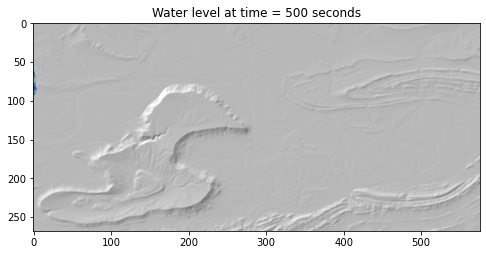

In [ ]:
%matplotlib inline

def plot(time_secs):
  plt.figure(figsize=(8, 8), dpi=100)
  plt.grid(False)
  plt.title(f'Water level at time = {time_secs} seconds')
  rgb = LightSource(azdeg=315, altdeg=45).hillshade(scaled_dem, vert_exag=.005)
  plt.imshow(rgb, alpha=1, cmap='gray', vmin=-.5, vmax=.9)

  # Apply the `Blues` cmap to the water heightmap manually, with alpha level
  # equal to the water height (so that the DEM shows through).
  x = scaled_heightmaps[time_secs]
  norm_x = .5 + .5 * (x / x.max())
  y = plt.cm.Blues(norm_x)
  y[..., -1] = x / x.max()
  plt.imshow(y)
  plt.show()

if PUBLIC_COLAB:
  slider = widgets.IntSlider(
      value=num_secs,
      min=start_time_secs + num_secs_per_cycle, max=num_secs,
      step=num_secs_per_cycle)
  out = widgets.interactive_output(
      lambda time_secs: plot(time_secs), {'time_secs': slider})
  display(widgets.VBox([slider, out]))
